In [1]:
import numpy as np
import sys
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    if test:
        w2_star = np.ones(r)
        W1_star = np.ones((r, d))
    else:
        w2_star = np.random.rand(r)
        W1_star = np.random.rand(r, d)
    M = w2_star @ W1_star
    inputs = np.random.rand(d, n) + 1 # add 1 to avoid everything being mean 0
    if test:
        M = np.ones(d)
        assert(np.all(np.equal(M @ inputs, np.sum(inputs, axis=0))))
    if no_noise:
        y = (M @ inputs).reshape(1, n)
    else:
        y = M @ inputs + np.random.normal(scale=eps, size=(1, n))
    y = y[0]
    inputs = np.transpose(inputs)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star


def split_sets(w2, W1, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = W1
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    def predict(xs, j):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out[:, j]
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = predict(sets[i][0], j)
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]
            # print(features)
            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert k != B - 1, 'features[sample_id]=' + str(features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_set(sample, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    features = W1 @ sample

    for i in range(len(set_ranges)):
        flag = True
        for j in range(len(features)):
            if not(features[j] >= set_ranges[i][j][0] and features[j] <= set_ranges[i][j][1]):
                flag = False
                break
        if flag:
            return i
    print("The given element", sample, "could not be contained within set_ranges")
    raise ValueError


def get_sets(samples, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    def predict(xs):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out
    
    features = predict(samples)
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, w1, W2, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, w1, W2, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(sample, r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_num = get_set(sample, r, w2, W1, quantiles_list, set_ranges)
    weights = D2_weights[set_num]
    counts = D2_counts[set_num]
    return weights / counts


def predict(xs, w2, W1, only_top=True):
    n = len(xs)
    if only_top:
        out = np.empty((n, len(xs[0])))
        for i in range(n):
            out[i] = W1 @ xs[i]
        return out
    out = np.empty(n)
    for i in range(n):
        out[i] = w2 @ W1 @ xs[i]
    return out


def get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, 
              x_valid, y_valid, n_train, n_valid, D2, plot):
    """Define the linear model and optimize
       d: number of dimensions of the input
       r: number of dimensions in the "second to last layer"
       eps: error added to true function in data
       lr: learning rate for gradient descent
       reg: choice of lambda for L2 regularization
       n_epochs: number of epochs to train for
    """
    mses = []

    assert(r == 1)
    w2 = np.random.rand(r)
    W1 = np.random.rand(r, d)

    for epoch in range(n_epochs):        
        mse = 0
        vals = []
        for i in range(n_valid):
            vals.append(w2 @ W1 @ x_valid[i])
            mse += (vals[-1] - y_valid[i])**2
        mse /= n_valid
        # print("Epoch", epoch, "validation MSE", mse)

        # At every epoch, run Linjun's method
        sets, set_counts, set_ranges, quantiles_list = split_sets(w2, W1, (x_train, y_train), C, B, r)
        if (epoch % 20 == 0 or epoch < 10) and plot:
            for s in sets:
                plt.plot(s[0], s[1], 'o')
            plt.xlabel('x')
            plt.title("Linjun's Sets at epoch " + str(epoch))
            plt.ylabel('y')
            plt.show()
        
        #print(set_ranges)
        D2_counts, D2_weights = compute_D2(D2, r, w2, W1, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                raise ValueError

        # Check the accuracy
        fhat_test = np.empty(n_test)
        for i in range(n_test):
            fhat_test[i] = fhat(x_test[i], r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges)
        if (epoch % 20 == 0 or epoch < 10) and plot:
            plt.plot(x_valid, y_valid, 'o', label='f')
            plt.plot(x_valid, vals, 'o', label='f*')
            plt.plot(x_valid, [vals[i] / w2[0] for i in range(len(vals))], 'o', label='h*')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.plot(x_test, fhat_test, 'o', label='fhat')
            plt.title("i_epoch=" + str(epoch))
            plt.legend()
            plt.show()
            
            print(w2)
            print(W1)
        mse_nn = np.square(predict(x_test, w2, W1, only_top=False) - y_test).mean()
        mse_fhat = np.square(np.subtract(fhat_test, y_test)).mean()
        print("FHT MSE:", mse_fhat)
        mses.append(mse_fhat)
        
        if epoch > 20 and epoch % 10 == 0:
            lr /= 2
        grads = np.zeros(r + d)
        for i in range(n_train):
            xi = x_train[i]
            yi = y_train[i]
            tmp = 2 * (w2 @ W1 @ xi - yi)
            grads[:r] += tmp * W1 @ xi 
            grads[r:] += tmp * w2 * xi
        w2 = w2 - lr * (grads[:r]) - reg * np.abs(w2)
        W1 = W1 - lr * (grads[r:]) - reg * np.abs(W1)

        # Print the function out
        #print(W1)
        #print(w2)
        
    return w2, W1, mses


Test that we get the Expected Results
-------------------------------------

1. First check that if we make D1 = D2, we never get an error because
   a feature cannot be placed 
2. Set d=1, r=1 and let the truth be ones--this is just y = x. Check that
   1. The gradient descent learns the correct function
   2. Fhat is "reasonable"--we expect that the sets will just be partitioned
      in the obvious way since the representation should just be the function 
      itself, up to some normalization. Thus, we expect Fhat to just be a 
      step function that partitions x into B roughly equal parts and has
      the correct average value
   3. Check that the sets themselves are correct
3. Set d=2, r=1 and let the truth be ones--this is also simple! Check all the
   same as the above.
   
4. See what happens when we start adding more noise. We expect the sets to 
   become increasingly distorted as the quantiles are perturbed by the noise.
   To confirm the results are what we expect, we could just compute the expected
   MSE using some Monte Carlo tests.

In [6]:
# Test #1...
C = 10000
n_train, n_valid, n_test = 300, 1000, 1000
r = 1
d = 5
eps=0
B = 64
lr = 0.000005 * 10
reg = 0.01
n_epochs = 100
D1, D2_o, x_valid, y_valid_o, x_test, y_test_o, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=True)
x_train = D1[0]
y_train_o = D1[1]

y_valid = y_valid_o + np.random.normal(scale=eps, size=(n_valid))
y_test = y_test_o + np.random.normal(scale=eps, size=(n_test))
D2 = D1 # even with a large B and small n_train, we shouldn't get an error
y_train = y_train_o + np.random.normal(scale=eps, size=(n_train // 2))
for i in range(5):
    w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, False)

FHT MSE: 0.0009119016228271592
FHT MSE: 0.0010241325445967257
FHT MSE: 0.0011531872577161706
FHT MSE: 0.0012249080741011142
FHT MSE: 0.0015663985562464227
FHT MSE: 0.0014758335410708827
FHT MSE: 0.0015831251448429695
FHT MSE: 0.0016132961525193346
FHT MSE: 0.0016422915977875685
FHT MSE: 0.0017285687494226001
FHT MSE: 0.00168794602400386
FHT MSE: 0.0017403135526892575
FHT MSE: 0.0018370832038337186
FHT MSE: 0.001927976374272257
FHT MSE: 0.0018739861845437301
FHT MSE: 0.0019141491932696893
FHT MSE: 0.0018750072945141927
FHT MSE: 0.0018534112068606214
FHT MSE: 0.0017453601040162234
FHT MSE: 0.0017537307196533072
FHT MSE: 0.001830783680188892
FHT MSE: 0.0019395376392838948
FHT MSE: 0.001971617822102751
FHT MSE: 0.001982257515000059
FHT MSE: 0.002002343632533597
FHT MSE: 0.00204442034990186
FHT MSE: 0.0019981552249084414
FHT MSE: 0.0019706143603237733
FHT MSE: 0.0021046505345795187
FHT MSE: 0.0020735502680549038
FHT MSE: 0.0020248433985602275
FHT MSE: 0.0020374201263693567
FHT MSE: 0.002021

FHT MSE: 0.002241932689620193
FHT MSE: 0.002241932689620193
FHT MSE: 0.002245903857995367
FHT MSE: 0.002248217138700121
FHT MSE: 0.0022493340519227833
FHT MSE: 0.0022511289521843425
FHT MSE: 0.0022511289521843425
FHT MSE: 0.0022506484620149233
FHT MSE: 0.00225258410770049
FHT MSE: 0.0022496555715763875
FHT MSE: 0.0022480608040400876
FHT MSE: 0.0022437643618642812
FHT MSE: 0.002239936670937012
FHT MSE: 0.0022404869577548362
FHT MSE: 0.0022404869577548362
FHT MSE: 0.0022404869577548362
FHT MSE: 0.0022381110288729267
FHT MSE: 0.0022234620563529716
FHT MSE: 0.0022234620563529716
FHT MSE: 0.0022234620563529716
FHT MSE: 0.0022234620563529716
FHT MSE: 0.0022234620563529716
FHT MSE: 0.0022234620563529716
FHT MSE: 0.0022234620563529716
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0022284715114725506
FHT MSE: 0.0012

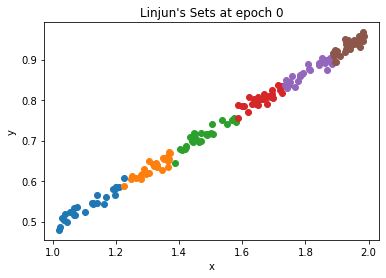

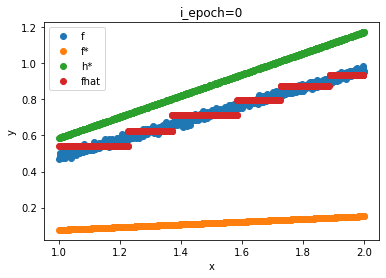

[0.12942179]
[[0.58632842]]
FHT MSE: 0.0007119472224972463


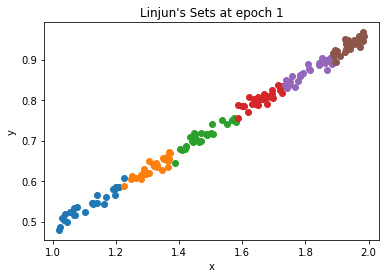

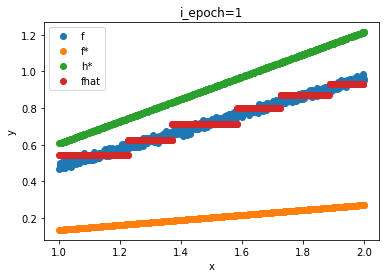

[0.22405964]
[[0.60666032]]
FHT MSE: 0.0007119472224972463


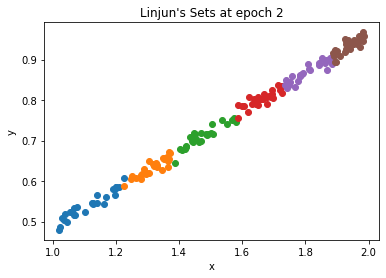

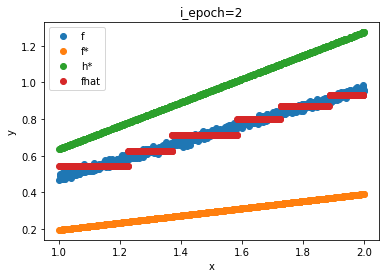

[0.30740396]
[[0.63691821]]
FHT MSE: 0.0007119472224972463


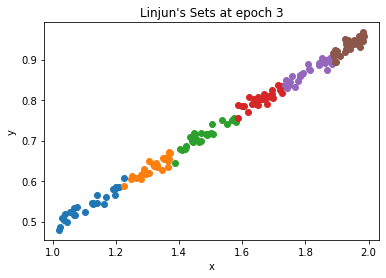

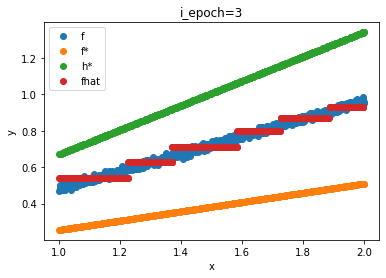

[0.37967139]
[[0.67130901]]
FHT MSE: 0.0007119472224972463


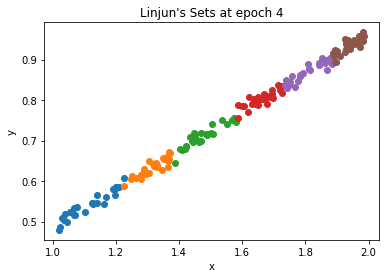

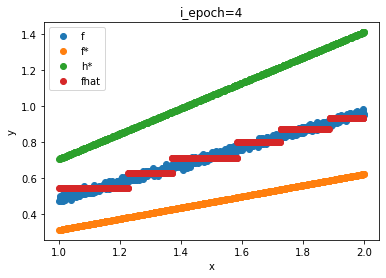

[0.44001252]
[[0.70497949]]
FHT MSE: 0.0007119472224972463


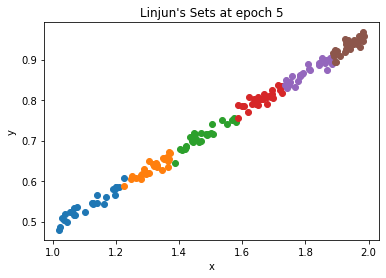

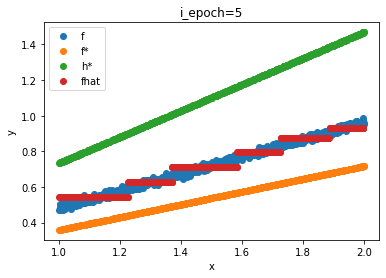

[0.48782981]
[[0.73439428]]
FHT MSE: 0.0007119472224972463


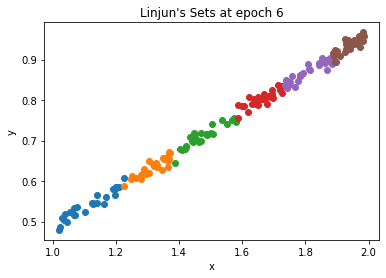

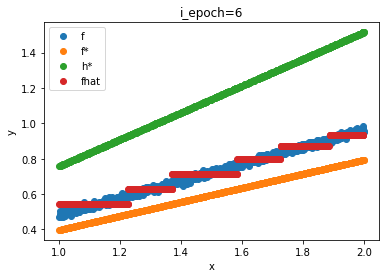

[0.52357778]
[[0.75772993]]
FHT MSE: 0.0007119472224972463


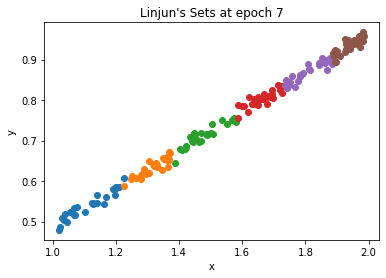

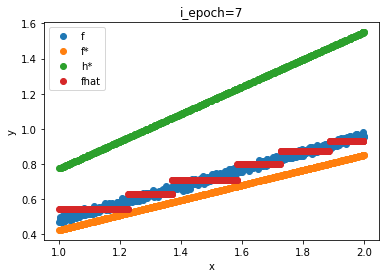

[0.54884957]
[[0.77479634]]
FHT MSE: 0.0007119472224972463


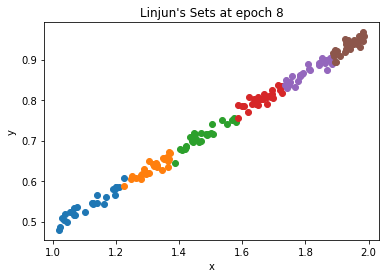

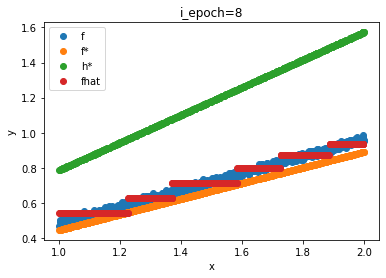

[0.5658913]
[[0.78648234]]
FHT MSE: 0.0007119472224972463


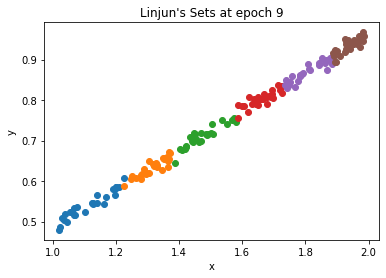

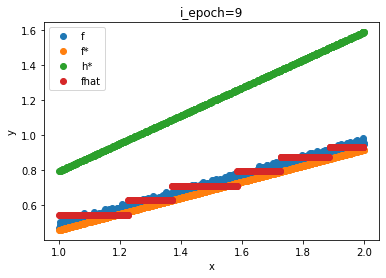

[0.57698365]
[[0.79408422]]
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463


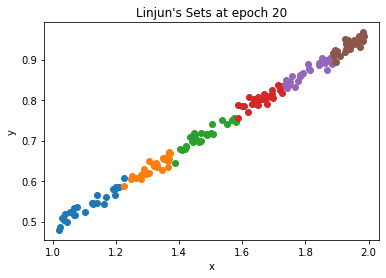

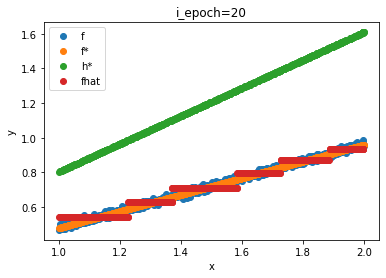

[0.59655539]
[[0.80436778]]
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463


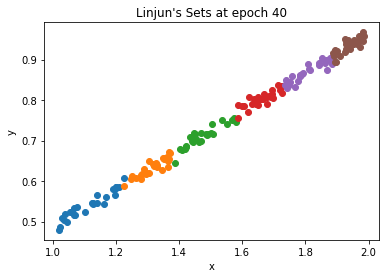

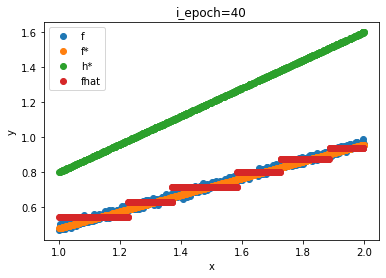

[0.59831088]
[[0.79854865]]
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463


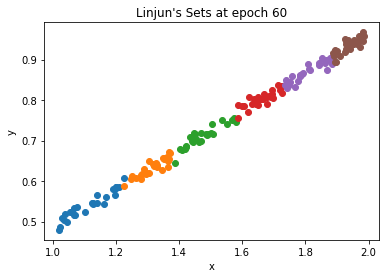

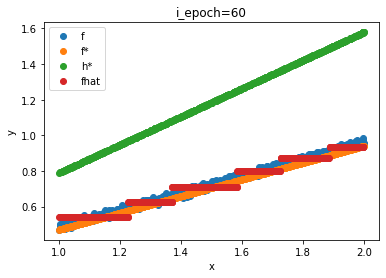

[0.59534074]
[[0.78940492]]
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463


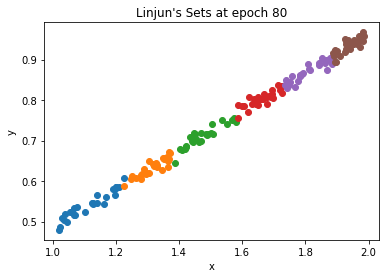

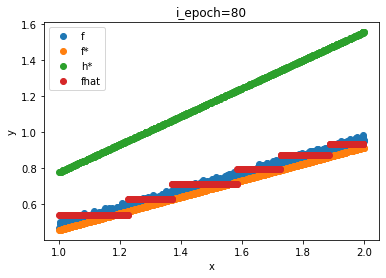

[0.5884953]
[[0.77750467]]
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463
FHT MSE: 0.0007119472224972463


In [8]:
# Test #2...
C = 100000
n_train, n_valid, n_test = 320, 1000, 1000
eps = 0.01
r = 1
B = 6
lr = 0.0001 * 5
reg = 0.001
n_epochs = 100
d = 1
D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False)
x_train = D1[0]
y_train = D1[1]
w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, True)


In [34]:
def get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    if test:
        w2_star = np.ones(r)
        W1_star = np.array([1, 0]).reshape(r, d)#np.ones((r, d))
    else:
        w2_star = np.random.rand(r)
        W1_star = np.random.rand(r, d)
    M = w2_star @ W1_star
    inputs = np.random.rand(d, n) + 1 # add 1 to avoid everything being mean 0
    if no_noise:
        y = (M @ inputs).reshape(1, n)
    else:
        y = M @ inputs + np.random.normal(scale=eps, size=(1, n))
    y = y[0]
    inputs = np.transpose(inputs)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star


def split_sets(w2, W1, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = W1
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    def predict(xs, j):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out[:, j]
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = predict(sets[i][0], j)
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]
            # print(features)
            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert k != B - 1, 'features[sample_id]=' + str(features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_set(sample, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    features = W1 @ sample

    for i in range(len(set_ranges)):
        flag = True
        for j in range(len(features)):
            if not(features[j] >= set_ranges[i][j][0] and features[j] <= set_ranges[i][j][1]):
                flag = False
                break
        if flag:
            return i
    print("The given element", sample, "could not be contained within set_ranges")
    raise ValueError


def get_sets(samples, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    def predict(xs):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out
    
    features = predict(samples)
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, w1, W2, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, w1, W2, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(sample, r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_num = get_set(sample, r, w2, W1, quantiles_list, set_ranges)
    weights = D2_weights[set_num]
    counts = D2_counts[set_num]
    return weights / counts


def predict(xs, w2, W1, only_top=True):
    n = len(xs)
    if only_top:
        out = np.empty((n, len(xs[0])))
        for i in range(n):
            out[i] = W1 @ xs[i]
        return out
    out = np.empty(n)
    for i in range(n):
        out[i] = w2 @ W1 @ xs[i]
    return out


def get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, 
              x_valid, y_valid, n_train, n_valid, D2, good=False, bad=False, star=None, plot=True):
    """Define the linear model and optimize
       d: number of dimensions of the input
       r: number of dimensions in the "second to last layer"
       eps: error added to true function in data
       lr: learning rate for gradient descent
       reg: choice of lambda for L2 regularization
       n_epochs: number of epochs to train for
    """
    mses = []

    assert(r == 1)
    w2 = np.random.rand(r)
    W1 = np.random.rand(r, d)
    if good:
        w2 = star[0]
        W1 = star[1]
    elif bad:
        w2 = np.ones(r)
        #pref = 1. / (star[1][0][0] - star[1][0][1]) 
        #W1[0, 0] = -pref * (w2**2 * star[1][0][1] * (star[1][0][0] + star[1][0][1]) + 1) 
        #W1[0, 1] = pref * (w2**2 * star[1][0][0] * (star[1][0][0] + star[1][0][1]) + 1) 
        W1[0, 0] = -1
        W1[0, 1] = 0
        
    for epoch in range(n_epochs):        
        mse = 0
        vals = []
        for i in range(n_valid):
            vals.append(w2 @ W1 @ x_valid[i])
            mse += (vals[-1] - y_valid[i])**2
        mse /= n_valid

        # At every epoch, run Linjun's method
        sets, set_counts, set_ranges, quantiles_list = split_sets(w2, W1, (x_train, y_train), C, B, r)
        if (epoch < 5 or epoch == 20) and plot:
            %matplotlib inline 
            fig = plt.figure()
            # Let's just get a top down view--we don't care about z values
            #ax = fig.add_subplot(projection='3d')
            for s in sets:
                plt.plot(s[0][:, 0], s[0][:, 1], 'o')
            plt.xlabel('x')
            plt.title("Linjun's Sets at epoch " + str(epoch))
            plt.ylabel('y')
            plt.show()
        
        D2_counts, D2_weights = compute_D2(D2, r, w2, W1, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                raise ValueError

        # Check the accuracy
        fhat_test = np.empty(n_test)
        for i in range(n_test):
            fhat_test[i] = fhat(x_test[i], r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges)
        if (epoch < 5 or epoch == 20) and plot:
            %matplotlib inline 
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            
            plt.plot(x_valid[:, 0], x_valid[:, 1], y_valid, 'o', label='f', alpha=0.5)
            plt.plot(x_valid[:, 0], x_valid[:, 1], vals, 'o', label='f*', alpha=0.5)
            plt.plot(x_valid[:, 0], x_valid[:, 1], [vals[i] / w2[0] for i in range(len(vals))], 'o', label='h*')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.plot(x_test[:, 0], x_test[:, 1], fhat_test, 'o', label='fhat', alpha=0.5)
            plt.title("i_epoch=" + str(epoch))
            plt.legend()
            plt.show()
            
            print(w2, star[0])
            print(W1, star[1])
        mse_nn = np.square(predict(x_test, w2, W1, only_top=False) - y_test).mean()
        mse_fhat = np.square(np.subtract(fhat_test, y_test)).mean()
        print("FHT MSE:", mse_fhat)
        mses.append(mse_fhat)
        
        if epoch > 20 and epoch % 10 == 0:
            lr /= 2
        grads = np.zeros(r + d)
        for i in range(n_train):
            xi = x_train[i]
            yi = y_train[i]
            tmp = 2 * (w2 @ W1 @ xi - yi)
            grads[:r] += tmp * W1 @ xi 
            grads[r:] += tmp * w2 * xi
        w2 = w2 - lr * (grads[:r]) - reg * np.abs(w2)
        W1 = W1 - lr * (grads[r:]) - reg * np.abs(W1)
        
    return w2, W1, mses

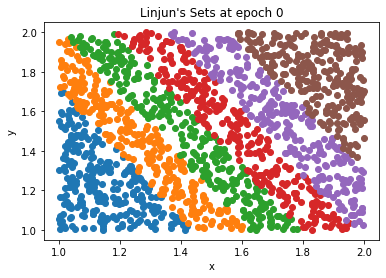

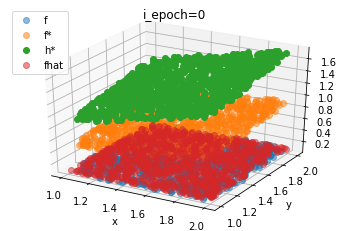

[0.53357822]
[[0.55114982 0.33711131]]
FHT MSE: 0.00016139620600254695


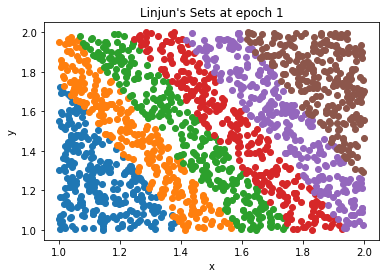

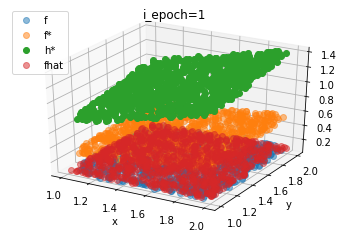

[0.39822844]
[[0.46922629 0.25642502]]
FHT MSE: 0.00016761756853776743


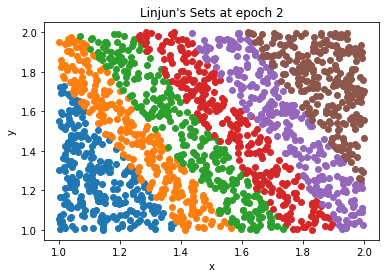

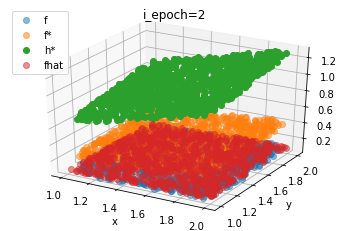

[0.3368064]
[[0.43505789 0.22306389]]
FHT MSE: 0.00017019956165060894


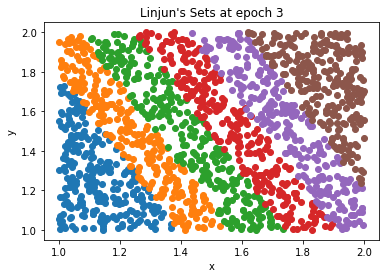

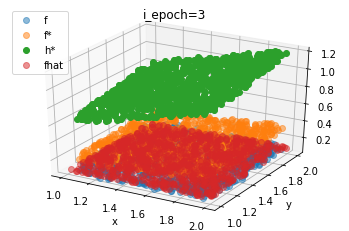

[0.29733676]
[[0.41444713 0.20310391]]
FHT MSE: 0.00017191404487118718


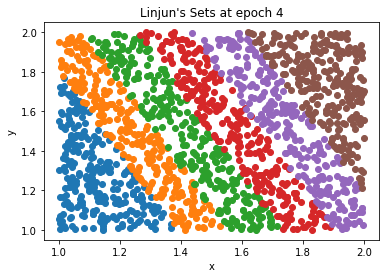

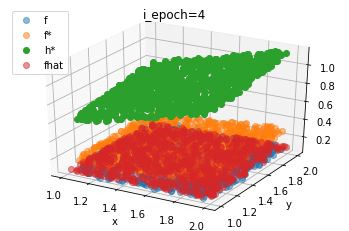

[0.26891703]
[[0.40037685 0.1895963 ]]
FHT MSE: 0.00017376105945473468
FHT MSE: 0.00017486489096177476
FHT MSE: 0.00017622651877090295
FHT MSE: 0.00017732644071723032
FHT MSE: 0.00017798780942350774
FHT MSE: 0.0001784396218077298
FHT MSE: 0.00017924863139472607
FHT MSE: 0.0001796883163648119
FHT MSE: 0.00018006003862948512
FHT MSE: 0.00018023252933242374
FHT MSE: 0.0001805256467886695
FHT MSE: 0.00018055576740233015
FHT MSE: 0.00018068635178681574
FHT MSE: 0.00018067741372474654
FHT MSE: 0.00018061720763522113
FHT MSE: 0.00018091459460854747


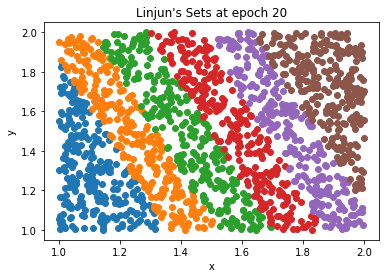

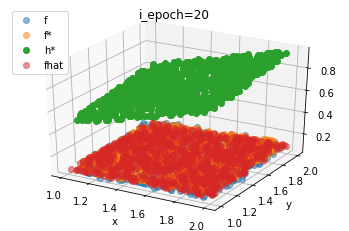

[0.14326288]
[[0.34600438 0.14112987]]
FHT MSE: 0.00018096360859169553
FHT MSE: 0.00018098404689960069
FHT MSE: 0.00018124635269404574
FHT MSE: 0.00018086348186200824
FHT MSE: 0.00018124635269404574
FHT MSE: 0.0001812868189340734
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.0001809410786580194
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018091279702125458
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.00018132257942608416
FHT MSE: 0.0001812868189340734
FHT MSE: 0.0001812868189340734
FHT M

In [15]:
# Test #3... (new version of the code so we can still run Test #2)
C = 100000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01 
r = 1
B = 6
lr = 0.00001 * 5
reg = 0.001
n_epochs = 100
d = 2
D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False)
x_train = D1[0]
y_train = D1[1]
w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2)


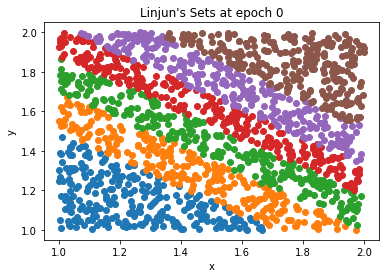

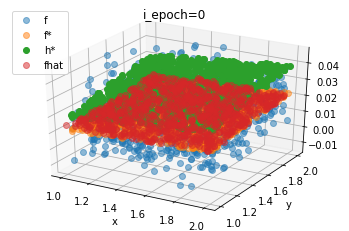

[0.57573633]
[[0.0080925  0.01153654]]
FHT MSE: 9.621268661529059e-05


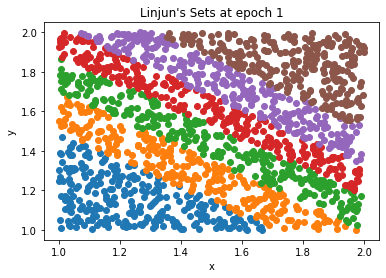

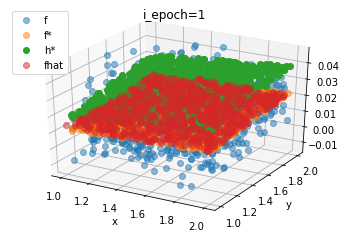

[0.57515986]
[[0.00806558 0.01150149]]
FHT MSE: 9.621268661529059e-05


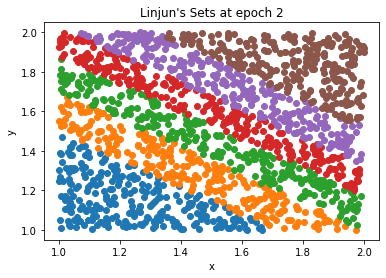

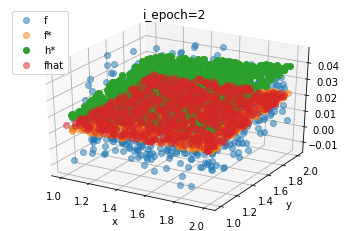

[0.57458431]
[[0.00804861 0.01147654]]
FHT MSE: 9.621268661529059e-05


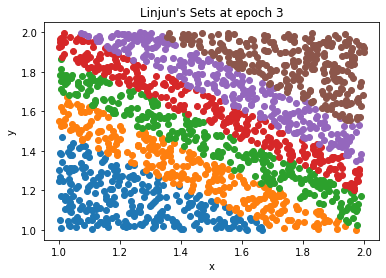

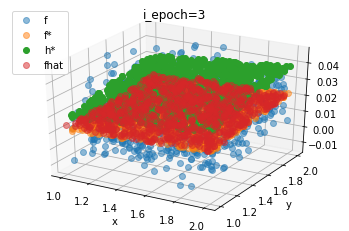

[0.57400958]
[[0.00803911 0.0114592 ]]
FHT MSE: 9.619885144860238e-05


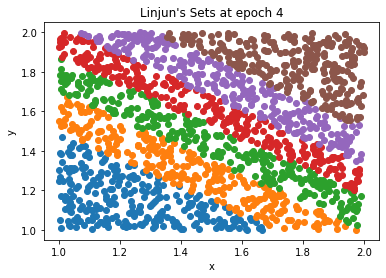

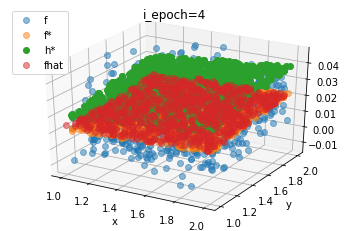

[0.57343563]
[[0.00803522 0.01144757]]
FHT MSE: 9.621358495879326e-05
FHT MSE: 9.62481955637574e-05
FHT MSE: 9.61404486627885e-05
FHT MSE: 9.629845169010828e-05
FHT MSE: 9.628120406655048e-05
FHT MSE: 9.623894626930598e-05
FHT MSE: 9.625757245685844e-05
FHT MSE: 9.625101976352857e-05
FHT MSE: 9.625290043688193e-05
FHT MSE: 9.62404359411866e-05
FHT MSE: 9.62298968735405e-05
FHT MSE: 9.620315067671081e-05
FHT MSE: 9.620367732753466e-05
FHT MSE: 9.619411904747493e-05
FHT MSE: 9.618275961473229e-05
FHT MSE: 9.617477459790438e-05


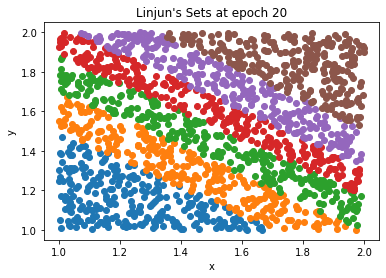

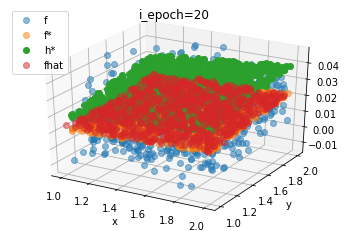

[0.56433777]
[[0.0081931  0.01149189]]
FHT MSE: 9.615884069977927e-05
FHT MSE: 9.619226372628329e-05
FHT MSE: 9.621653153163772e-05
FHT MSE: 9.621162730943255e-05
FHT MSE: 9.621162730943255e-05
FHT MSE: 9.613832305624875e-05
FHT MSE: 9.61390057899521e-05
FHT MSE: 9.613370488581387e-05
FHT MSE: 9.614037893152881e-05
FHT MSE: 9.615312140123473e-05
FHT MSE: 9.614154755476421e-05
FHT MSE: 9.617899715933903e-05
FHT MSE: 9.617899715933903e-05
FHT MSE: 9.614126742350587e-05
FHT MSE: 9.611191705131328e-05
FHT MSE: 9.6119322907857e-05
FHT MSE: 9.611983371047151e-05
FHT MSE: 9.611983371047151e-05
FHT MSE: 9.611983371047151e-05
FHT MSE: 9.611983371047151e-05
FHT MSE: 9.611908764659286e-05
FHT MSE: 9.611908764659286e-05
FHT MSE: 9.611908764659286e-05
FHT MSE: 9.611908764659286e-05
FHT MSE: 9.611908764659286e-05
FHT MSE: 9.608576107943062e-05
FHT MSE: 9.608576107943062e-05
FHT MSE: 9.610952549242611e-05
FHT MSE: 9.614114649195196e-05
FHT MSE: 9.614114649195196e-05
FHT MSE: 9.613496513923426e-05
FHT

In [17]:
# Now we have a much better idea of what is going on. Next, for d=2, we want to compare the best and 
# worst cases. The best case is that we randomly guess the correct initial plane. In this case, the 
# error should be bounded by B and epsilon from the start and should not change much. 
# The worst case is we guess something perpendicular. In this case, we expect the error to start off 
# large and then we will slowly watch the partitioning lines change as we get closer to the correct plane
C = 100000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01 
r = 1
B = 6
lr = 0.00001 * 5
reg = 0.001
n_epochs = 100
d = 2
D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False)
x_train = D1[0]
y_train = D1[1]
w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, good=True, bad=False, star=(w2_star, W1_star))

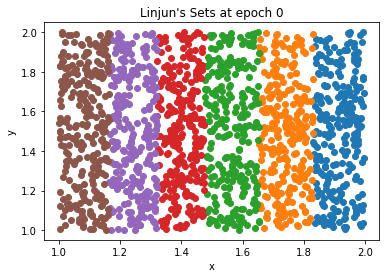

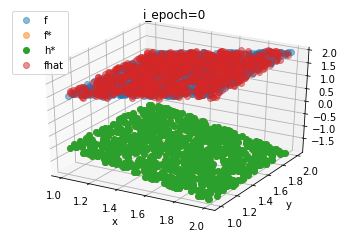

[1.] [1.]
[[-1.  0.]] [[1 0]]
FHT MSE: 0.002399311831114888


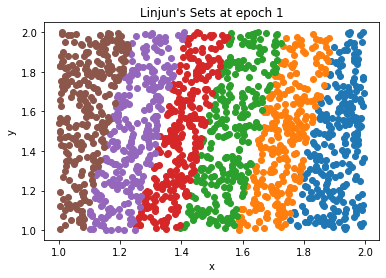

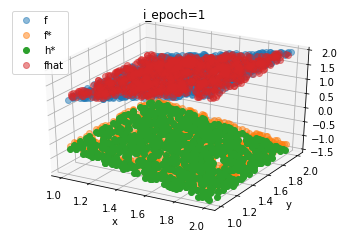

[0.851287] [1.]
[[-0.853287    0.14309498]] [[1 0]]
FHT MSE: 0.00456363180308449


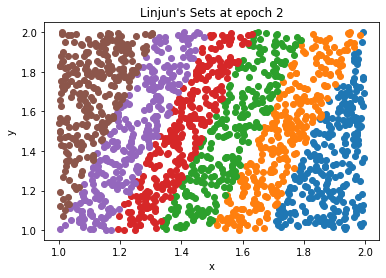

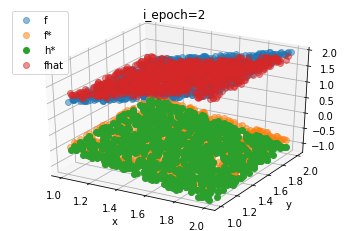

[0.76544768] [1.]
[[-0.7530152   0.24036635]] [[1 0]]
FHT MSE: 0.009306181288743665


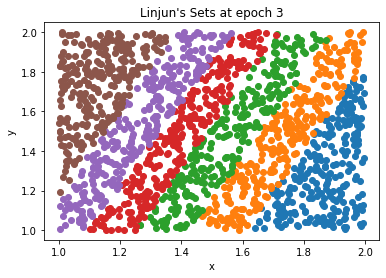

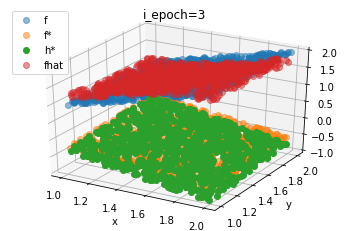

[0.7107335] [1.]
[[-0.67472445  0.31595282]] [[1 0]]
FHT MSE: 0.015614665212257801


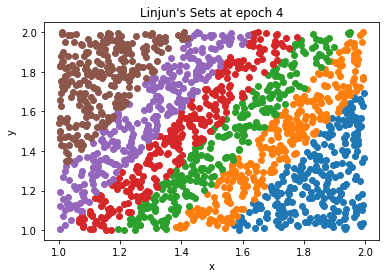

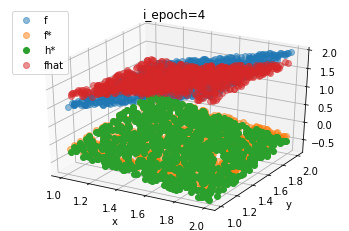

[0.67528532] [1.]
[[-0.60915182  0.37896797]] [[1 0]]
FHT MSE: 0.022903529235156414
FHT MSE: 0.031459340500068114
FHT MSE: 0.03934669221890684
FHT MSE: 0.04495628610197618
FHT MSE: 0.05089091705411571
FHT MSE: 0.05661705270780306
FHT MSE: 0.061132539856750615
FHT MSE: 0.06500629314813489
FHT MSE: 0.06917716351384944
FHT MSE: 0.07235430142784255
FHT MSE: 0.07527905887349216
FHT MSE: 0.07649990955895611
FHT MSE: 0.07697316944430588
FHT MSE: 0.0775336266223574
FHT MSE: 0.07800704301429345
FHT MSE: 0.07832650845804495


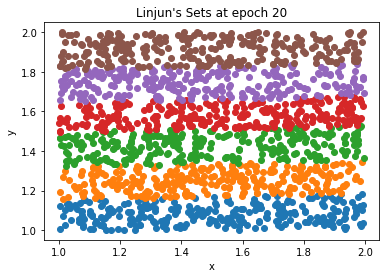

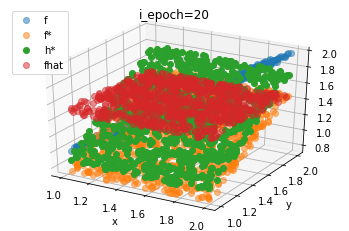

[0.84880213] [1.]
[[-0.02736514  0.90589626]] [[1 0]]
FHT MSE: 0.07856159206529995
FHT MSE: 0.07855539239805824
FHT MSE: 0.07873771204902218
FHT MSE: 0.0787508016264047
FHT MSE: 0.0787959239137416
FHT MSE: 0.07876240248309209
FHT MSE: 0.07878321164085955
FHT MSE: 0.07884204660531965
FHT MSE: 0.07902051598792457
FHT MSE: 0.07911395788385271
FHT MSE: 0.07907394202402708
FHT MSE: 0.07910797073583942
FHT MSE: 0.07918691254086867
FHT MSE: 0.07914120484879593
FHT MSE: 0.07916969258376759
FHT MSE: 0.07921307432518025
FHT MSE: 0.0791240846302994
FHT MSE: 0.07919417160669397
FHT MSE: 0.0791125376143043
FHT MSE: 0.0791964350353272
FHT MSE: 0.07922905475674713
FHT MSE: 0.0792848449869068
FHT MSE: 0.07927836479229884
FHT MSE: 0.0792735223508195
FHT MSE: 0.0792719205166072
FHT MSE: 0.07925467298439363
FHT MSE: 0.07926771637698864
FHT MSE: 0.07933449313361171
FHT MSE: 0.07941166611873288
FHT MSE: 0.07932171727867876
FHT MSE: 0.07934209937613829
FHT MSE: 0.07939351245164267
FHT MSE: 0.079422725636243

In [35]:
C = 100000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01 
r = 1
B = 6
lr = 0.00001
reg = 0.001
n_epochs = 100
d = 2
D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=True, no_noise=False)
x_train = D1[0]
y_train = D1[1]
w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, good=False, bad=True, star=(w2_star, W1_star))

In [37]:
# Which is exactly what we wanted to see!! Our last test is to see how the distribution of bad starting values
# changes as we modify d (keeping r=1 and B, eps fixed to something reasonable)
# I suspect the distribution will shift such that there are more bad values at higher dimensions, 
# which will explain why we saw "mode collapse" in the initial plots I sent to Zhun

C = 100000
n_train, n_valid, n_test = 320, 1000, 1000
eps = 0.01 
r = 1
B = 6
lr = 0.0001 * 5
reg = 0.001
n_epochs = 1
mse2 = []
for d in [2, 3, 4, 5, 6, 7, 8]:
    mse1 = []
    for i in range(500):
        D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=True)
        x_train = D1[0]
        y_train = D1[1]
        w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, plot=False)
        mse1.extend(mses)
    mse2.append(mse1)

FHT MSE: 0.0035816728892597203
FHT MSE: 0.0009419077609085207
FHT MSE: 0.0016544034787322824
FHT MSE: 1.2162470950146824e-06
FHT MSE: 5.5959325322430626e-05
FHT MSE: 0.00834696627590672
FHT MSE: 0.004106693079308481
FHT MSE: 0.0004163106056556314
FHT MSE: 0.0012930790557781951
FHT MSE: 0.003427665991492915
FHT MSE: 1.0844581090825081e-06
FHT MSE: 0.005918711004467605
FHT MSE: 7.387331442785124e-05
FHT MSE: 0.000865086274357205
FHT MSE: 0.00013373302094608263
FHT MSE: 0.0028369155474604977
FHT MSE: 0.005857789962170606
FHT MSE: 0.0008565948273176492
FHT MSE: 0.001457988047879806
FHT MSE: 0.0008513465026613045
FHT MSE: 0.002856663218802907
FHT MSE: 0.003547490617464912
FHT MSE: 0.0006273360829678266
FHT MSE: 0.0017881743613664086
FHT MSE: 0.009737358528760618
FHT MSE: 0.00583088609054097
FHT MSE: 0.0017494402852546813
FHT MSE: 9.427422718661066e-06
FHT MSE: 0.004625958268768565
FHT MSE: 0.0010078379401741336
FHT MSE: 0.0015084540864862927
FHT MSE: 2.8687351754812413e-05
FHT MSE: 0.001205

FHT MSE: 0.007982158699150046
FHT MSE: 0.01707366074321044
FHT MSE: 0.007882007538125449
FHT MSE: 0.003774308962818032
FHT MSE: 4.8042182843317444e-05
FHT MSE: 0.010290919080906995
FHT MSE: 0.002997827279561421
FHT MSE: 8.833825811686688e-05
FHT MSE: 7.916083229402329e-05
FHT MSE: 0.0035426317130228605
FHT MSE: 0.008362512217303955
FHT MSE: 0.02329292597175948
FHT MSE: 0.014381510320600772
FHT MSE: 0.004537155502914358
FHT MSE: 0.0023726370834159763
FHT MSE: 0.0005792326617997173
FHT MSE: 7.04884601439551e-05
FHT MSE: 0.0009694487293690186
FHT MSE: 0.002446201046936433
FHT MSE: 0.002442623654673255
FHT MSE: 0.01393165360991051
FHT MSE: 0.040667050913579146
FHT MSE: 0.000739638442656549
FHT MSE: 0.0034905330539354486
FHT MSE: 0.006715814219476515
FHT MSE: 0.010652468249559842
FHT MSE: 0.06226744453598896
FHT MSE: 0.0021341479777768797
FHT MSE: 0.00038193723991406653
FHT MSE: 7.067745157498593e-05
FHT MSE: 0.005662619583957653
FHT MSE: 1.7643279992137196e-05
FHT MSE: 0.000952977325088657

FHT MSE: 0.0007159695756512975
FHT MSE: 0.0007489095636447617
FHT MSE: 0.0011669096390951885
FHT MSE: 0.0014662023290724798
FHT MSE: 0.011310222187314298
FHT MSE: 0.00171968211244852
FHT MSE: 0.0019667834989669955
FHT MSE: 0.003761804048779432
FHT MSE: 0.0085052834787566
FHT MSE: 0.0011800363386145897
FHT MSE: 0.01751727596151523
FHT MSE: 0.03088165446154254
FHT MSE: 0.0035325361813023405
FHT MSE: 0.0010204095175022458
FHT MSE: 0.00026765071822616206
FHT MSE: 0.0009716068148468194
FHT MSE: 0.01124388786708305
FHT MSE: 0.0022659336334582957
FHT MSE: 0.01050630812067087
FHT MSE: 0.01349110548072435
FHT MSE: 0.00016455720662423892
FHT MSE: 0.013784784136596883
FHT MSE: 4.616190735443714e-06
FHT MSE: 0.00031789370882362434
FHT MSE: 0.0019788326383097347
FHT MSE: 0.018438957364721502
FHT MSE: 0.0031854597130215423
FHT MSE: 0.018782028540762104
FHT MSE: 2.539386556532944e-05
FHT MSE: 0.011667729307157138
FHT MSE: 5.983654413600444e-05
FHT MSE: 0.0005966912704311905
FHT MSE: 0.000924309627749

FHT MSE: 0.011867820166735538
FHT MSE: 0.0013440968064076793
FHT MSE: 0.00027918876310382805
FHT MSE: 0.006357870337442967
FHT MSE: 0.0024321921516479456
FHT MSE: 0.0002368855485272885
FHT MSE: 0.00016253284462585432
FHT MSE: 0.012073327198241448
FHT MSE: 0.001738864894712036
FHT MSE: 0.0018653644883674446
FHT MSE: 0.009926458014227176
FHT MSE: 0.002387025276985149
FHT MSE: 0.007715602612239237
FHT MSE: 0.015501976004565028
FHT MSE: 0.0017052579958716186
FHT MSE: 0.0018443420897339177
FHT MSE: 0.004254597522404355
FHT MSE: 0.00487611211040745
FHT MSE: 0.00012930958969693666
FHT MSE: 0.008428103607776205
FHT MSE: 0.0035571297996850352
FHT MSE: 0.02166636186988914
FHT MSE: 0.006048300382627348
FHT MSE: 1.6697202732898628e-05
FHT MSE: 0.0038800288268566996
FHT MSE: 0.019452546134708273
FHT MSE: 0.0019774413745158254
FHT MSE: 0.006928036344046798
FHT MSE: 0.011078849604226533
FHT MSE: 0.009066068936005079
FHT MSE: 0.0020509912832568453
FHT MSE: 0.009489673855888765
FHT MSE: 0.0001731272382

FHT MSE: 0.008943776629486673
FHT MSE: 0.000708059237341861
FHT MSE: 0.0004657606843322866
FHT MSE: 0.0024949835723328765
FHT MSE: 0.006079734122346282
FHT MSE: 0.0012047926848934415
FHT MSE: 0.02841447634257334
FHT MSE: 0.038592233327553446
FHT MSE: 0.014581516616475469
FHT MSE: 0.0032014410914680312
FHT MSE: 0.0010112897121424378
FHT MSE: 0.00011756015319937776
FHT MSE: 0.0010298096542558702
FHT MSE: 0.0015943465630947327
FHT MSE: 0.008640897053699028
FHT MSE: 0.016903495550584003
FHT MSE: 0.015463471275095727
FHT MSE: 3.890878267822783e-05
FHT MSE: 0.022610091919775237
FHT MSE: 0.03798734865174525
FHT MSE: 0.005265888626429144
FHT MSE: 0.02467526327705701
FHT MSE: 0.045245258910282686
FHT MSE: 0.017979981554313816
FHT MSE: 3.255841612440954e-05
FHT MSE: 0.011029996278474936
FHT MSE: 0.02919327244330449
FHT MSE: 0.007034584083986381
FHT MSE: 0.061054240583508446
FHT MSE: 0.002947912368871513
FHT MSE: 0.00015378612636909967
FHT MSE: 0.0402553489432415
FHT MSE: 0.009583065183932373
FHT

FHT MSE: 0.009560497196452005
FHT MSE: 0.0015321507195702516
FHT MSE: 0.04086350744896204
FHT MSE: 0.022573401226220195
FHT MSE: 0.02039061179812849
FHT MSE: 0.015622053157615202
FHT MSE: 0.011157342479684315
FHT MSE: 0.015223017426890703
FHT MSE: 0.0022008659566548645
FHT MSE: 0.0008133887331905844
FHT MSE: 0.00041271123492908016
FHT MSE: 0.00024563922904915705
FHT MSE: 0.03181584276278259
FHT MSE: 1.2073149067354132e-05
FHT MSE: 0.0029030452139182407
FHT MSE: 0.013498491511917347
FHT MSE: 0.0016010720859976355
FHT MSE: 0.001494266906883428
FHT MSE: 0.01729627002353787
FHT MSE: 0.05325805564389331
FHT MSE: 0.014591615016612384
FHT MSE: 0.0073396807361715164
FHT MSE: 0.0006414553015484214
FHT MSE: 0.0018271121391721437
FHT MSE: 0.006438718588680659
FHT MSE: 0.0017098249767758204
FHT MSE: 0.035448837513373264
FHT MSE: 0.0022421383490952925
FHT MSE: 3.4977400066411794e-06
FHT MSE: 0.018562285935318376
FHT MSE: 0.054229396109233406
FHT MSE: 0.015053939609303405
FHT MSE: 4.312099385556947e

FHT MSE: 0.005392549781209927
FHT MSE: 0.002282582928349708
FHT MSE: 0.019896149089613832
FHT MSE: 0.006931117165065839
FHT MSE: 0.03613706969954151
FHT MSE: 0.007106777061919074
FHT MSE: 0.012139346951942659
FHT MSE: 0.021500282665700948
FHT MSE: 0.006268512410174292
FHT MSE: 0.01584379466517193
FHT MSE: 0.05495380466355837
FHT MSE: 0.020089152106382662
FHT MSE: 0.03337909375957634
FHT MSE: 0.007323894389120135
FHT MSE: 0.09861937830516228
FHT MSE: 0.008855472888288191
FHT MSE: 0.037305192124059035
FHT MSE: 0.06018408145865601
FHT MSE: 0.00024636838397874345
FHT MSE: 0.0017208297951862735
FHT MSE: 0.001105008195517462
FHT MSE: 0.023877010150432292
FHT MSE: 0.1300326940903816
FHT MSE: 0.062031097781044674
FHT MSE: 0.02616133258088199
FHT MSE: 0.0010419018040960656
FHT MSE: 0.044900052789583055
FHT MSE: 0.015390914701865085
FHT MSE: 0.0019738019795349465
FHT MSE: 0.003298807355591955
FHT MSE: 0.011686794426662466
FHT MSE: 0.043208786150321275
FHT MSE: 0.004316356539116157
FHT MSE: 0.001

FHT MSE: 0.0173306823525084
FHT MSE: 0.0019342814520102026
FHT MSE: 0.004569433946671463
FHT MSE: 0.025732063590406654
FHT MSE: 0.0649257410703677
FHT MSE: 0.02647306394803073
FHT MSE: 0.04663248527480106
FHT MSE: 0.006101073878451906
FHT MSE: 0.005911857423580946
FHT MSE: 0.0003462781037845192
FHT MSE: 0.014759625775022062
FHT MSE: 0.003775887608515153
FHT MSE: 0.0006629061829679968
FHT MSE: 0.008088602590952813
FHT MSE: 0.05997383469827287
FHT MSE: 0.008043757239937112
FHT MSE: 0.02752445535916058
FHT MSE: 0.000956296148118734
FHT MSE: 0.00272319445239675
FHT MSE: 0.007692346414422767
FHT MSE: 0.002870915490397681
FHT MSE: 0.013843425783229082
FHT MSE: 0.0016083565392222153
FHT MSE: 0.04549827739071222
FHT MSE: 0.04722919111579684
FHT MSE: 0.06791154427298617
FHT MSE: 0.008352924813955944
FHT MSE: 0.001260294166036207
FHT MSE: 0.01516322429290609
FHT MSE: 0.011193079087705803
FHT MSE: 0.054860406687258174
FHT MSE: 0.003802980764486318
FHT MSE: 0.0294752016966304
FHT MSE: 0.0004431964

FHT MSE: 9.53623886633387e-05
FHT MSE: 0.0069999263277081255
FHT MSE: 0.0035167546610254366
FHT MSE: 0.006232396745083566
FHT MSE: 0.042461378872487375
FHT MSE: 0.0865035838412414
FHT MSE: 0.02849361746757537
FHT MSE: 0.0015495704054551984
FHT MSE: 0.0005657535489890769
FHT MSE: 0.00025612539163303856
FHT MSE: 0.006752885652133488
FHT MSE: 0.012184912316331932
FHT MSE: 0.0014662236480801798
FHT MSE: 0.024871504510780313
FHT MSE: 2.4054133783398427e-08
FHT MSE: 5.76858279238273e-05
FHT MSE: 0.0006057836401252807
FHT MSE: 0.0025732987481334995
FHT MSE: 0.013674670674069102
FHT MSE: 0.0005309015436090394
FHT MSE: 0.006413468874230912
FHT MSE: 0.06257130524833074
FHT MSE: 0.010278838987745464
FHT MSE: 0.006278458753819877
FHT MSE: 0.08285017002052551
FHT MSE: 0.02377915714206177
FHT MSE: 0.0014703488345226
FHT MSE: 0.024020413920599268
FHT MSE: 0.033410541812183114
FHT MSE: 0.013170043745606756
FHT MSE: 0.030276013843032152
FHT MSE: 0.00020217038176705186
FHT MSE: 0.009362993759208472
FHT 

FHT MSE: 0.010167036000769568
FHT MSE: 0.11646451613897754
FHT MSE: 0.02838427449924383
FHT MSE: 0.07701327612667733
FHT MSE: 0.05858715433424327
FHT MSE: 0.049498784317501265
FHT MSE: 0.03270456996096736
FHT MSE: 0.004915197487762242
FHT MSE: 0.0009826491467705232
FHT MSE: 0.08139399437480935
FHT MSE: 0.005644877878311355
FHT MSE: 0.010334622096015732
FHT MSE: 0.04250026604629435
FHT MSE: 0.055718983206678674
FHT MSE: 0.0018811292121800932
FHT MSE: 0.025783773880061187
FHT MSE: 0.08182730339543676
FHT MSE: 0.07631020300917231
FHT MSE: 0.03508356178088804
FHT MSE: 0.005279678679724772
FHT MSE: 0.0016115442209341548
FHT MSE: 0.02207562386706684
FHT MSE: 0.0047743025592084
FHT MSE: 0.0051280943087857606
FHT MSE: 0.008299828444464266
FHT MSE: 0.003687685765861277
FHT MSE: 0.009207384680591893
FHT MSE: 0.0020509870019563337
FHT MSE: 0.03728770753070145
FHT MSE: 0.010803776929251255
FHT MSE: 0.02593556012060868
FHT MSE: 0.02890974507501466
FHT MSE: 0.04708402045634679
FHT MSE: 0.00767898001

FHT MSE: 0.020033959156376725
FHT MSE: 0.0374193285872136
FHT MSE: 0.003350676826325792
FHT MSE: 0.013060923219503782
FHT MSE: 0.00938226310707046
FHT MSE: 0.003675902459976487
FHT MSE: 0.003441627499903948
FHT MSE: 0.002016710943960743
FHT MSE: 0.07643599410716609
FHT MSE: 0.0007502546322785493
FHT MSE: 0.002115385802429743
FHT MSE: 0.06221029094274007
FHT MSE: 0.0005005495975792747
FHT MSE: 0.0022782088639805766
FHT MSE: 0.0040995423026771605
FHT MSE: 0.0033830890440981185
FHT MSE: 0.0011727305665668508
FHT MSE: 0.00034406691297434925
FHT MSE: 0.011467337562503677
FHT MSE: 0.0374932892136372
FHT MSE: 0.05207353596800046
FHT MSE: 0.0013606513994663075
FHT MSE: 0.0007645700082383857
FHT MSE: 0.00872184642832914
FHT MSE: 0.0005819948817092588
FHT MSE: 0.00394162036806956
FHT MSE: 0.042003477889884025
FHT MSE: 0.00665663166560484
FHT MSE: 0.05033496731097514
FHT MSE: 0.052331311683504564
FHT MSE: 0.0048421557366319055
FHT MSE: 0.0001284941202642459
FHT MSE: 0.01937180165694329
FHT MSE: 0

FHT MSE: 0.055177808621867254
FHT MSE: 0.05136662778985863
FHT MSE: 0.07258390252342559
FHT MSE: 0.0651828155771731
FHT MSE: 0.00918292528435125
FHT MSE: 0.000562351950583402
FHT MSE: 0.01882500449212342
FHT MSE: 0.003929017251000548
FHT MSE: 0.014954607377582087
FHT MSE: 0.010984268569097984
FHT MSE: 0.00029143895522060534
FHT MSE: 0.1073416663665596
FHT MSE: 0.013930633794615307
FHT MSE: 0.01252572448188446
FHT MSE: 0.08903994297318346
FHT MSE: 0.01477108675173491
FHT MSE: 0.021125014858253473
FHT MSE: 0.10457279782510653
FHT MSE: 0.027148015681222448
FHT MSE: 0.09531184787542867
FHT MSE: 0.06344222421435408
FHT MSE: 0.09566045584747153
FHT MSE: 0.07811274726011001
FHT MSE: 0.005269386625091419
FHT MSE: 0.002935963900440594
FHT MSE: 0.011937454646003083
FHT MSE: 0.03320857002464158
FHT MSE: 0.03761355037590472
FHT MSE: 0.005492500838181563
FHT MSE: 0.07823830855721456
FHT MSE: 0.0009762065273479647
FHT MSE: 0.00032837436521275434
FHT MSE: 0.006517525544490919
FHT MSE: 0.0403799091278

FHT MSE: 0.03287360096102777
FHT MSE: 0.08920467038272216
FHT MSE: 0.002187523197488037
FHT MSE: 0.02652492989890145
FHT MSE: 0.019694050347203052
FHT MSE: 0.08774925572859979
FHT MSE: 0.0008301822174216659
FHT MSE: 0.06256806810778917
FHT MSE: 0.007620051260169984
FHT MSE: 0.0019694694893481607
FHT MSE: 0.011625581866156406
FHT MSE: 5.677872676347853e-05
FHT MSE: 1.2884060423679668e-05
FHT MSE: 0.01173045768554938
FHT MSE: 0.00284476482750082
FHT MSE: 0.02086964431635089
FHT MSE: 0.005280721304481446
FHT MSE: 0.002302880388162194
FHT MSE: 0.005022053852533806
FHT MSE: 0.08803177801858596
FHT MSE: 0.03757675612034538
FHT MSE: 0.007396835350662567
FHT MSE: 0.0008670133712559865
FHT MSE: 0.04756205522758381
FHT MSE: 0.04565069317286495
FHT MSE: 0.009449904408843338
FHT MSE: 0.00093363704355904
FHT MSE: 0.002552939496659983
FHT MSE: 0.02954366570060239
FHT MSE: 0.012681662311620802
FHT MSE: 0.011342613000142793
FHT MSE: 0.087279607417179
FHT MSE: 0.07527530448723604
FHT MSE: 0.00213189874

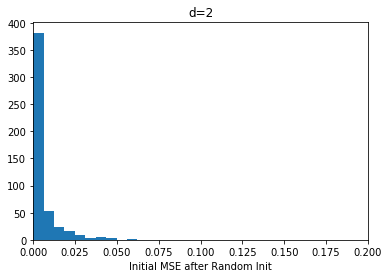

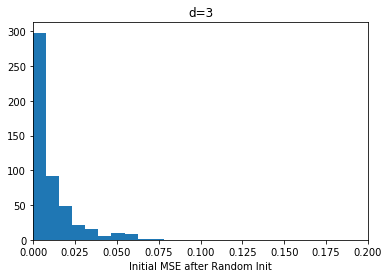

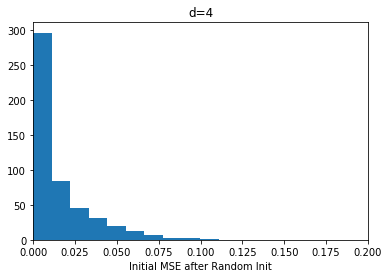

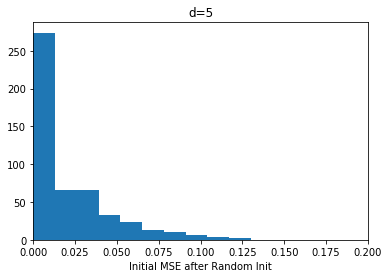

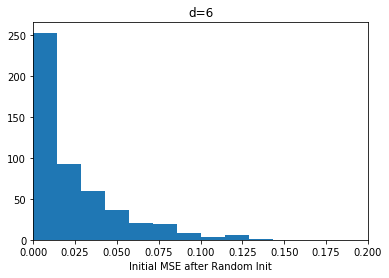

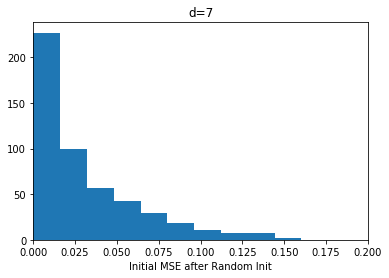

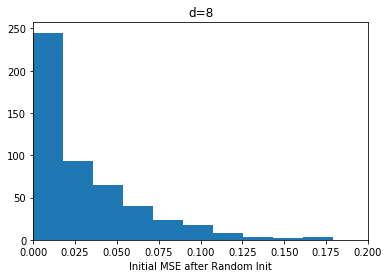

In [38]:
ds = [2, 3, 4, 5, 6, 7, 8]
for i in range(len(ds)):
    plt.hist(mse2[i])
    plt.title("d=" + str(ds[i]))
    plt.xlim(0, 0.2)
    plt.xlabel("Initial MSE after Random Init")
    plt.show()

In [41]:
# Wonderful, that solves that mystery!! Let's try adding some noise and seeing what happens--good we see
# that for lower values of d, the distribution is slightly less skewed, but it doesn't really matter
# if d gets larger, which I think is what I would expect
C = 100000
n_train, n_valid, n_test = 320, 1000, 1000
eps = 0.02 
r = 1
B = 6
lr = 0.0001 * 5
reg = 0.001
n_epochs = 1
mse2 = []
for d in [2, 3, 4, 5, 6, 7, 8]:
    mse1 = []
    for i in range(500):
        D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False)
        x_train = D1[0]
        y_train = D1[1]
        w2, W1, mses = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, plot=False)
        mse1.extend(mses)
    mse2.append(mse1)

FHT MSE: 0.00042913717868560967
FHT MSE: 0.0005249812541412908
FHT MSE: 0.001274284191585222
FHT MSE: 0.0017323801710115287
FHT MSE: 0.0056436653176473225
FHT MSE: 0.0013213102729223878
FHT MSE: 0.00857219179756818
FHT MSE: 0.00040746766658511014
FHT MSE: 0.0015192326349272312
FHT MSE: 0.005657986793324472
FHT MSE: 0.00042411131532620885
FHT MSE: 0.0007847777661709444
FHT MSE: 0.00038993925957225823
FHT MSE: 0.002134846270503086
FHT MSE: 0.0006608541500113814
FHT MSE: 0.0004389021872609742
FHT MSE: 0.00044798100871724954
FHT MSE: 0.0004607440868750164
FHT MSE: 0.0011544077871539992
FHT MSE: 0.0009022992453874656
FHT MSE: 0.0011251038323302554
FHT MSE: 0.002915721087119628
FHT MSE: 0.0005798692130214179
FHT MSE: 0.0009356263165296104
FHT MSE: 0.00998072050774826
FHT MSE: 0.01646764371319117
FHT MSE: 0.0008879222543988408
FHT MSE: 0.0030720870843183663
FHT MSE: 0.0034668007215450593
FHT MSE: 0.0011218682536270816
FHT MSE: 0.030663519766183558
FHT MSE: 0.00043563811744770664
FHT MSE: 0.00

FHT MSE: 0.009863454488529232
FHT MSE: 0.0024977050286423275
FHT MSE: 0.011073446873708743
FHT MSE: 0.004508703964200956
FHT MSE: 0.006192029187727596
FHT MSE: 0.0009628623051780907
FHT MSE: 0.0012556200997471453
FHT MSE: 0.0006144448351308298
FHT MSE: 0.004514648777079767
FHT MSE: 0.038741865226280585
FHT MSE: 0.019109520625491
FHT MSE: 0.04446944767099707
FHT MSE: 0.00251565324643389
FHT MSE: 0.01794111023050847
FHT MSE: 0.007634358556527551
FHT MSE: 0.006696939991722642
FHT MSE: 0.0032533842111958713
FHT MSE: 0.01931260573252643
FHT MSE: 0.002812623535041076
FHT MSE: 0.0016332725656665243
FHT MSE: 0.0009623932594007229
FHT MSE: 0.012799683102165879
FHT MSE: 0.006630343283809509
FHT MSE: 0.003869200032097206
FHT MSE: 0.05040148082919869
FHT MSE: 0.004401449570857251
FHT MSE: 0.00041605848425474407
FHT MSE: 0.0013049145694547894
FHT MSE: 0.0014057504681098934
FHT MSE: 0.0009638680442997566
FHT MSE: 0.030584548978492342
FHT MSE: 0.0004371564763242003
FHT MSE: 0.006313807936411405
FHT M

FHT MSE: 0.001668644085656675
FHT MSE: 0.002745856481389481
FHT MSE: 0.03407908543250565
FHT MSE: 0.00042369467599003994
FHT MSE: 0.0004909620717682459
FHT MSE: 0.006001093087960228
FHT MSE: 0.0011743944675707359
FHT MSE: 0.02302374846477864
FHT MSE: 0.010019030812575817
FHT MSE: 0.03203382035447387
FHT MSE: 0.022626667779733857
FHT MSE: 0.008661128766809386
FHT MSE: 0.01075935052137363
FHT MSE: 0.04225115757354509
FHT MSE: 0.006657230887531341
FHT MSE: 0.010984567998448864
FHT MSE: 0.004470990160766638
FHT MSE: 0.0006343474812710955
FHT MSE: 0.01869010780446466
FHT MSE: 0.004500639662088938
FHT MSE: 0.029926510870109085
FHT MSE: 0.005943710985864977
FHT MSE: 0.019606780059721194
FHT MSE: 0.006895318561850053
FHT MSE: 0.00803719594303037
FHT MSE: 0.01896782525983221
FHT MSE: 0.010244775089728502
FHT MSE: 0.0008594160776122791
FHT MSE: 0.0015764766671232033
FHT MSE: 0.03686585289744764
FHT MSE: 0.0005627141759059085
FHT MSE: 0.036776074641808314
FHT MSE: 0.024083453346460146
FHT MSE: 0.

FHT MSE: 0.0029714530766746607
FHT MSE: 0.017495675763982435
FHT MSE: 0.002394915150197323
FHT MSE: 0.0015103528581312414
FHT MSE: 0.0008409455387870294
FHT MSE: 0.0007841450675940596
FHT MSE: 0.0005138542815334514
FHT MSE: 0.0036794543609446314
FHT MSE: 0.004640431346128963
FHT MSE: 0.014476401790157002
FHT MSE: 0.010319657866915563
FHT MSE: 0.012056727109545537
FHT MSE: 0.011319358065732551
FHT MSE: 0.0030811576263714735
FHT MSE: 0.005580845752896154
FHT MSE: 0.0005796180750563565
FHT MSE: 0.015615935966714296
FHT MSE: 0.0034270987717268863
FHT MSE: 0.002395758212843737
FHT MSE: 0.0009705688292224186
FHT MSE: 0.04929646148269263
FHT MSE: 0.016797962098046987
FHT MSE: 0.05204547474095128
FHT MSE: 0.002635110619466216
FHT MSE: 0.012902869531198888
FHT MSE: 0.05516631802302257
FHT MSE: 0.002045135056202055
FHT MSE: 0.0004624648355950303
FHT MSE: 0.0006700097959437314
FHT MSE: 0.029999770126646435
FHT MSE: 0.001179865908290386
FHT MSE: 0.006235378701784901
FHT MSE: 0.03587703445481863
FH

FHT MSE: 0.0003871818198981068
FHT MSE: 0.004265732550034361
FHT MSE: 0.0010729639445540044
FHT MSE: 0.007009330298434456
FHT MSE: 0.0010193057495939853
FHT MSE: 0.0004683227080675317
FHT MSE: 0.016485903857970344
FHT MSE: 0.010887013701327402
FHT MSE: 0.0019288812857744739
FHT MSE: 0.006311302420163739
FHT MSE: 0.003682507770746091
FHT MSE: 0.02238424162417241
FHT MSE: 0.000681531916290082
FHT MSE: 0.005537661836400972
FHT MSE: 0.001475580423379016
FHT MSE: 0.02403507816829761
FHT MSE: 0.0020899291886622776
FHT MSE: 0.02245065197733296
FHT MSE: 0.0006575404554513939
FHT MSE: 0.010024763758788156
FHT MSE: 0.0037564265984033297
FHT MSE: 0.09044023199870975
FHT MSE: 0.006300519766492002
FHT MSE: 0.018169969190636223
FHT MSE: 0.04312085026684126
FHT MSE: 0.002796185749513807
FHT MSE: 0.0005324670660047792
FHT MSE: 0.015617478226987103
FHT MSE: 0.0025893590578975278
FHT MSE: 0.010681741299470726
FHT MSE: 0.003315998404461003
FHT MSE: 0.01357128435913448
FHT MSE: 0.0005752364247989685
FHT M

FHT MSE: 0.0220375480959519
FHT MSE: 0.030900937169326827
FHT MSE: 0.0004279929158921981
FHT MSE: 0.011867369744849357
FHT MSE: 0.0752103989148587
FHT MSE: 0.0025782610772428784
FHT MSE: 0.009454746203788634
FHT MSE: 0.0074831971042917
FHT MSE: 0.001424852737880424
FHT MSE: 0.021097235203782334
FHT MSE: 0.003374735381974811
FHT MSE: 0.03259405275354376
FHT MSE: 0.04521653908029818
FHT MSE: 0.015167633713758476
FHT MSE: 0.011568185659671689
FHT MSE: 0.00896734779552369
FHT MSE: 0.013656328558304766
FHT MSE: 0.016221171586243963
FHT MSE: 0.008915927956393198
FHT MSE: 0.016620591339725266
FHT MSE: 0.0003920670788130749
FHT MSE: 0.0014841975539392504
FHT MSE: 0.014360865638980865
FHT MSE: 0.0019093623173559646
FHT MSE: 0.0007237669746297973
FHT MSE: 0.0008754800196403584
FHT MSE: 0.044979193363608144
FHT MSE: 0.0006673411185194251
FHT MSE: 0.007705936653433772
FHT MSE: 0.045723872135546136
FHT MSE: 0.00040191095937510345
FHT MSE: 0.023880500790153206
FHT MSE: 0.000868819556812745
FHT MSE: 

FHT MSE: 0.0007846856578457102
FHT MSE: 0.021105554716280367
FHT MSE: 0.018654575574778474
FHT MSE: 0.043836058484793355
FHT MSE: 0.0004916535570802544
FHT MSE: 0.06488086357976855
FHT MSE: 0.02572813115128451
FHT MSE: 0.04095317985905024
FHT MSE: 0.03802531413566475
FHT MSE: 0.016507983804240362
FHT MSE: 0.06667226360657
FHT MSE: 0.023615342495745352
FHT MSE: 0.04521041242817924
FHT MSE: 0.030940952746554524
FHT MSE: 0.005903022133335827
FHT MSE: 0.023016763192395477
FHT MSE: 0.0013001443761740878
FHT MSE: 0.045239848651462494
FHT MSE: 0.09108701356465392
FHT MSE: 0.0009259483009881926
FHT MSE: 0.016715092462994133
FHT MSE: 0.0427177028223345
FHT MSE: 0.0730831994467822
FHT MSE: 0.016066464046892624
FHT MSE: 0.028439339758467682
FHT MSE: 0.006375253972037851
FHT MSE: 0.0004216212558460397
FHT MSE: 0.0004759242643661648
FHT MSE: 0.010379234867988162
FHT MSE: 0.02672183098687669
FHT MSE: 0.0015720213384766014
FHT MSE: 0.008019880511291771
FHT MSE: 0.029885017077799496
FHT MSE: 0.0025306

FHT MSE: 0.0017526655132752002
FHT MSE: 0.061207037898023654
FHT MSE: 0.0040205832966076094
FHT MSE: 0.000615234077599178
FHT MSE: 0.0040935992861035825
FHT MSE: 0.015817080408643828
FHT MSE: 0.026554856250790182
FHT MSE: 0.05558336249346546
FHT MSE: 0.05413860657097324
FHT MSE: 0.005953135966983323
FHT MSE: 0.00043477658137035957
FHT MSE: 0.0028659433294154803
FHT MSE: 0.0004640501487965368
FHT MSE: 0.05203681433640675
FHT MSE: 0.009554201753906623
FHT MSE: 0.0026154872819408323
FHT MSE: 0.0171427888239079
FHT MSE: 0.008514353464217141
FHT MSE: 0.015754183222087596
FHT MSE: 0.0028801809420999263
FHT MSE: 0.06042951082116535
FHT MSE: 0.04805850578993226
FHT MSE: 0.11345341439696656
FHT MSE: 0.0812852397296188
FHT MSE: 0.01898125031282492
FHT MSE: 0.012023019450231459
FHT MSE: 0.012565302756028449
FHT MSE: 0.013672753429758794
FHT MSE: 0.008228031542325652
FHT MSE: 0.053101180520118224
FHT MSE: 0.06443540902596638
FHT MSE: 0.01969936489767128
FHT MSE: 0.03645664852851238
FHT MSE: 0.0009

FHT MSE: 0.05364837274304831
FHT MSE: 0.03328783953813635
FHT MSE: 0.05183985615310102
FHT MSE: 0.043945577840843554
FHT MSE: 0.009915186125092533
FHT MSE: 0.02941435937820418
FHT MSE: 0.030785700159542635
FHT MSE: 0.027062587955188715
FHT MSE: 0.0008746106940701425
FHT MSE: 0.00047544691895085305
FHT MSE: 0.09479537854640134
FHT MSE: 0.07294273521979541
FHT MSE: 0.06180442822596328
FHT MSE: 0.003812646398113423
FHT MSE: 0.003589422679275561
FHT MSE: 0.014843263472854648
FHT MSE: 0.03607834503333828
FHT MSE: 0.001077107550227095
FHT MSE: 0.032180107139109806
FHT MSE: 0.06873197313686004
FHT MSE: 0.02575869469180294
FHT MSE: 0.024735637455258135
FHT MSE: 0.03847622996063732
FHT MSE: 0.01118807481950127
FHT MSE: 0.026029681928696393
FHT MSE: 0.025895752462311027
FHT MSE: 0.08933130990311815
FHT MSE: 0.03864151290857261
FHT MSE: 0.0007979949653153136
FHT MSE: 0.06148583938403179
FHT MSE: 0.00497197713466256
FHT MSE: 0.018074093682742664
FHT MSE: 0.0013815206260231376
FHT MSE: 0.0233875168

FHT MSE: 0.009026544410123108
FHT MSE: 0.012965612810687543
FHT MSE: 0.0005691317525221719
FHT MSE: 0.0008034648472212445
FHT MSE: 0.09027281748582934
FHT MSE: 0.010165855960175564
FHT MSE: 0.008359887079475381
FHT MSE: 0.007345952877626969
FHT MSE: 0.08156620786234811
FHT MSE: 0.04196895331411847
FHT MSE: 0.023371051050356983
FHT MSE: 0.0023605728671868783
FHT MSE: 0.004022810745095245
FHT MSE: 0.10893371528866945
FHT MSE: 0.0028207626320828974
FHT MSE: 0.0018206155170762482
FHT MSE: 0.0005172358486525821
FHT MSE: 0.08328293385067534
FHT MSE: 0.004289100484405067
FHT MSE: 0.07298870729402891
FHT MSE: 0.02179102068271618
FHT MSE: 0.002576128973469757
FHT MSE: 0.022402560901006473
FHT MSE: 0.002313501044615999
FHT MSE: 0.014662853905380118
FHT MSE: 0.000465555569557641
FHT MSE: 0.16029984555676366
FHT MSE: 0.00044177393502361687
FHT MSE: 0.0007633374403191715
FHT MSE: 0.017689498003796846
FHT MSE: 0.005742076437917882
FHT MSE: 0.02326251139590901
FHT MSE: 0.023965175618189536
FHT MSE: 0

FHT MSE: 0.05514099336872489
FHT MSE: 0.02102573423296522
FHT MSE: 0.06426720943996188
FHT MSE: 0.06384467997335029
FHT MSE: 0.011526884749897846
FHT MSE: 0.13947598873398548
FHT MSE: 0.010941915159078913
FHT MSE: 0.058951978162349934
FHT MSE: 0.013304273118896277
FHT MSE: 0.02244229686137827
FHT MSE: 0.01071727656151793
FHT MSE: 0.003633869317778836
FHT MSE: 0.05219732696832088
FHT MSE: 0.02140301235803112
FHT MSE: 0.0008898771293061039
FHT MSE: 0.03169740129351971
FHT MSE: 0.01137516173399323
FHT MSE: 0.02205161125985538
FHT MSE: 0.01577229095777397
FHT MSE: 0.003032661162411626
FHT MSE: 0.0019352404497910993
FHT MSE: 0.006534548593564788
FHT MSE: 0.10171008529377863
FHT MSE: 0.02850338971609309
FHT MSE: 0.05800573082241756
FHT MSE: 0.014580158197645085
FHT MSE: 0.004675200486049731
FHT MSE: 0.03979405870358451
FHT MSE: 0.0010510971101489015
FHT MSE: 0.020658710879430244
FHT MSE: 0.03562351638172246
FHT MSE: 0.011269292999565876
FHT MSE: 0.0031884626734120926
FHT MSE: 0.0930738211451

FHT MSE: 0.003319972758534829
FHT MSE: 0.04539247271507095
FHT MSE: 0.013761406594957592
FHT MSE: 0.033226749852901034
FHT MSE: 0.07595126467618737
FHT MSE: 0.040801591025118225
FHT MSE: 0.04009620697326638
FHT MSE: 0.0018585894103307656
FHT MSE: 0.0006634351498870168
FHT MSE: 0.041304364691567064
FHT MSE: 0.001226256472756162
FHT MSE: 0.09439344775927273
FHT MSE: 0.0015100214614959518
FHT MSE: 0.010687176825066397
FHT MSE: 0.09696250613620888
FHT MSE: 0.09105778290113588
FHT MSE: 0.06133716581032456
FHT MSE: 0.018230831138021552
FHT MSE: 0.0656085992307202
FHT MSE: 0.011681295251599255
FHT MSE: 0.00829289607039134
FHT MSE: 0.01606998750702901
FHT MSE: 0.022996718359727275
FHT MSE: 0.0026091737044964293
FHT MSE: 0.07787515073896983
FHT MSE: 0.02019450459183293
FHT MSE: 0.011075168040122726
FHT MSE: 0.01832751894954722
FHT MSE: 0.002845165820112053
FHT MSE: 0.07547310776943911
FHT MSE: 0.06835518028856945
FHT MSE: 0.06684425640250452
FHT MSE: 0.04277779363967996
FHT MSE: 0.0311871167260

FHT MSE: 0.003451844343234714
FHT MSE: 0.031073822821812112
FHT MSE: 0.0011370218304466563
FHT MSE: 0.02837637201037162
FHT MSE: 0.008024826151776184
FHT MSE: 0.00854921013301
FHT MSE: 0.023145323226566344
FHT MSE: 0.01661346066340883
FHT MSE: 0.08200799586729164
FHT MSE: 0.1186048486531747
FHT MSE: 0.0004955096416072077
FHT MSE: 0.01031040238027572
FHT MSE: 0.0006140672671322166
FHT MSE: 0.003813370244918535
FHT MSE: 0.02865045830801042
FHT MSE: 0.11983236487918615
FHT MSE: 0.04271069764447972
FHT MSE: 0.0012849602752006554
FHT MSE: 0.02168594744333587
FHT MSE: 0.015172143001258647
FHT MSE: 0.034392565929406205
FHT MSE: 0.00754942176700255
FHT MSE: 0.009261437832148047
FHT MSE: 0.10891644111046268
FHT MSE: 0.020834853658166095
FHT MSE: 0.03598450579651971
FHT MSE: 0.0006904675270024785
FHT MSE: 0.026151934244927233
FHT MSE: 0.029533866293996888
FHT MSE: 0.07693268197628796
FHT MSE: 0.000824823890759453
FHT MSE: 0.004447413526075886
FHT MSE: 0.04110783310563275
FHT MSE: 0.0080843416060

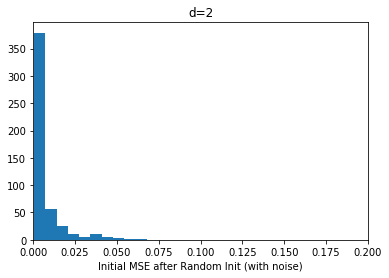

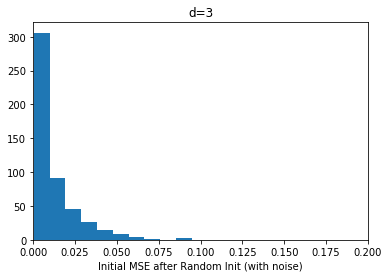

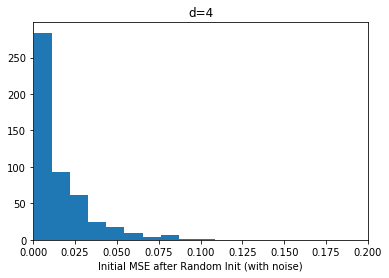

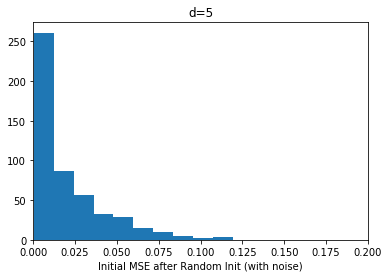

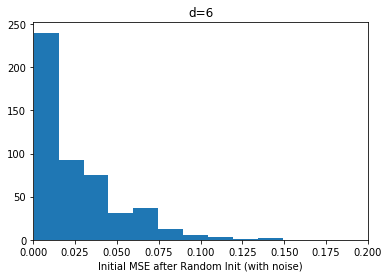

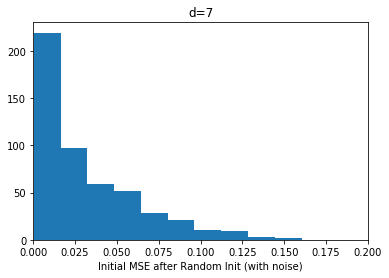

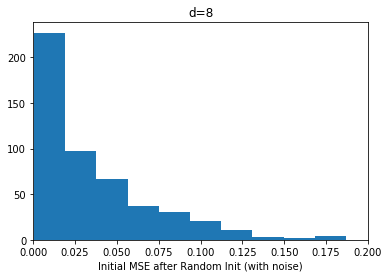

In [42]:
ds = [2, 3, 4, 5, 6, 7, 8]
for i in range(len(ds)):
    plt.hist(mse2[i])
    plt.title("d=" + str(ds[i]))
    plt.xlim(0, 0.2)
    plt.xlabel("Initial MSE after Random Init (with noise)")
    plt.show()

In [43]:
def get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False):
    """Define the ground truth"""
    n = n_train + n_valid + n_test
    if test:
        w2_star = np.ones(r)
        W1_star = np.ones((r, d))
    else:
        w2_star = np.random.rand(r)
        W1_star = np.random.rand(r, d)
    M = w2_star @ W1_star
    inputs = np.random.rand(d, n) + 1 # add 1 to avoid everything being mean 0
    if test:
        M = np.ones(d)
        assert(np.all(np.equal(M @ inputs, np.sum(inputs, axis=0))))
    if no_noise:
        y = (M @ inputs).reshape(1, n)
    else:
        y = M @ inputs + np.random.normal(scale=eps, size=(1, n))
    y = y[0]
    inputs = np.transpose(inputs)
    x_train, x_valid, x_test = inputs[:n_train], inputs[n_train:n_train + n_valid], inputs[n_train + n_valid:]
    y_train, y_valid, y_test = y[:n_train], y[n_train:n_train + n_valid], y[n_train + n_valid:]

    # First half of training data is D1, second is D2
    D1 = x_train[:n_train // 2], y_train[:n_train // 2]
    D2 = x_train[n_train // 2:], y_train[n_train // 2:]

    return D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star


def split_sets(w2, W1, D1, C, B, r):
    """Split D1 into sets by Linjun's method and get the corresponding intervals"""
    model = W1
    quantiles_B = np.linspace(0, 1, B + 1)
    sets = [D1]
    quantiles_list = []
    set_ranges = np.empty((1, r, 2))
    set_ranges[0, :, 0] = -C
    set_ranges[0, :, 1] = C
    
    def predict(xs, j):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out[:, j]
    
    for j in range(r):
        new_sets = []
        quantiles_tmp = []
        new_ranges = np.tile(set_ranges, (B, 1, 1))
        for i in range(len(sets)):
            features = predict(sets[i][0], j)
            quantiles = [-C] + list(np.quantile(features, quantiles_B[1:-1])) + [C]
            quantiles_tmp.append(quantiles)
            sets_tmp = [[] for i in range(B)]
            sets_tmp_y = [[] for i in range(B)]
            # print(features)
            for sample_id in range(len(sets[i][0])):
                for k in range(B):
                    if features[sample_id] >= quantiles[k] and features[sample_id] <= quantiles[k + 1]:
                        sets_tmp[k].append(sets[i][0][sample_id])
                        sets_tmp_y[k].append(sets[i][1][sample_id])
                        break
                    assert k != B - 1, 'features[sample_id]=' + str(features[sample_id])

            for k in range(B):
                new_ranges[k * B**j + i, j] = [quantiles[k], quantiles[k + 1]]
                new_sets.append((np.array(sets_tmp[k]), np.array(sets_tmp_y[k])))

        quantiles_list.append(quantiles_tmp)
        sets = new_sets
        set_ranges = new_ranges

    set_counts = [len(i[0]) for i in sets]
    return sets, set_counts, set_ranges, quantiles_list


def get_set(sample, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    features = W1 @ sample

    for i in range(len(set_ranges)):
        flag = True
        for j in range(len(features)):
            if not(features[j] >= set_ranges[i][j][0] and features[j] <= set_ranges[i][j][1]):
                flag = False
                break
        if flag:
            return i
    print("The given element", sample, "could not be contained within set_ranges")
    raise ValueError


def get_sets(samples, r, w2, W1, quantiles_list, set_ranges=None):
    """Determine which set a sample is in"""
    def predict(xs):
        n = len(xs)
        out = np.empty((n, len(xs[0])))
        for i in range(len(xs)):
            out[i] = W1 @ xs[i]
        return out
    
    features = predict(samples)
    ret = []
    for k, feature in enumerate(features):
        for i in range(len(set_ranges)):
            flag = True
            for j in range(len(set_ranges[i])):
                if not(feature[j] >= set_ranges[i][j][0] and feature[j] <= set_ranges[i][j][1]):
                    flag = False
                    break
            if flag:
                ret.append(i)
                break
            if i == len(set_ranges) - 1:
                raise ValueError("Couldn't place", feature, "within a set. feature corresponds to", samples[k], " input")
    return ret


def compute_D2(D2, r, w1, W2, quantiles_list, set_ranges=None):
    x, y = D2
    D2_counts = np.zeros(B**r)
    D2_weights = np.zeros(B**r)
    s = get_sets(D2[0], r, w1, W2, quantiles_list, set_ranges)

    for i in range(len(x)):
        D2_counts[s[i]] += 1
        D2_weights[s[i]] += y[i]
    return D2_counts, D2_weights


def fhat(sample, r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges):
    """Construct fhat from D2 samples"""
    set_num = get_set(sample, r, w2, W1, quantiles_list, set_ranges)
    weights = D2_weights[set_num]
    counts = D2_counts[set_num]
    return weights / counts


def predict(xs, w2, W1, only_top=True):
    n = len(xs)
    if only_top:
        out = np.empty((n, len(xs[0])))
        for i in range(n):
            out[i] = W1 @ xs[i]
        return out
    out = np.empty(n)
    for i in range(n):
        out[i] = w2 @ W1 @ xs[i]
    return out


def get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, 
              x_valid, y_valid, n_train, n_valid, D2, good=False, bad=False, star=None, plot=True):
    """Define the linear model and optimize
       d: number of dimensions of the input
       r: number of dimensions in the "second to last layer"
       eps: error added to true function in data
       lr: learning rate for gradient descent
       reg: choice of lambda for L2 regularization
       n_epochs: number of epochs to train for
    """
    mses = []

    assert(r == 1)
    w2 = np.random.rand(r)
    W1 = np.random.rand(r, d)
    if good:
        w2 = star[0]
        W1 = star[1]
    elif bad:
        w2 = star[0]
        W1[0, 0] = (star[1][0][1] - star[1][0][0]) * (w2**2 * star[1][0][1] * (star[1][0][0] + star[1][0][1]) + 1) 
        W1[0, 1] = -(star[1][0][1] - star[1][0][0]) * (w2**2 * star[1][0][0] * (star[1][0][0] + star[1][0][1]) + 1) 
        
    for epoch in range(n_epochs):        
        mse = 0
        vals = []
        for i in range(n_valid):
            vals.append(w2 @ W1 @ x_valid[i])
            mse += (vals[-1] - y_valid[i])**2
        mse /= n_valid

        # At every epoch, run Linjun's method
        sets, set_counts, set_ranges, quantiles_list = split_sets(w2, W1, (x_train, y_train), C, B, r)
        if epoch == 99 and plot:
            %matplotlib inline 
            fig = plt.figure()
            # Let's just get a top down view--we don't care about z values
            #ax = fig.add_subplot(projection='3d')
            for s in sets:
                plt.plot(s[0][:, 0], s[0][:, 1], 'o')
            plt.xlabel('x')
            plt.title("Linjun's Sets at epoch " + str(epoch))
            plt.ylabel('y')
            plt.show()
        
        D2_counts, D2_weights = compute_D2(D2, r, w2, W1, quantiles_list, set_ranges)

        # Check that nothing is 0
        for i in range(len(D2_counts)):
            if D2_counts[i] == 0:
                print("D2_counts was 0 at i =", i, "with set_ranges[i]:")
                print(set_ranges[i])
                raise ValueError

        # Check the accuracy
        fhat_test = np.empty(n_test)
        for i in range(n_test):
            fhat_test[i] = fhat(x_test[i], r, w2, W1, quantiles_list, D2_weights, D2_counts, set_ranges)
        if epoch == 99 and plot:
            %matplotlib inline 
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')
            
            plt.plot(x_valid[:, 0], x_valid[:, 1], y_valid, 'o', label='f', alpha=0.5)
            plt.plot(x_valid[:, 0], x_valid[:, 1], vals, 'o', label='f*', alpha=0.5)
            plt.plot(x_valid[:, 0], x_valid[:, 1], [vals[i] / w2[0] for i in range(len(vals))], 'o', label='h*')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.plot(x_test[:, 0], x_test[:, 1], fhat_test, 'o', label='fhat', alpha=0.5)
            plt.title("i_epoch=" + str(epoch))
            plt.legend()
            plt.show()
            
            print(w2)
            print(W1)
        mse_nn = np.square(predict(x_test, w2, W1, only_top=False) - y_test).mean()
        mse_fhat = np.square(np.subtract(fhat_test, y_test)).mean()
        if epoch == 99:
            print("FHT MSE:", mse_fhat, " and NN MSE:", mse_nn)
        mses.append(mse_fhat)
        
        if epoch > 20 and epoch % 10 == 0:
            lr /= 2
        grads = np.zeros(r + d)
        for i in range(n_train):
            xi = x_train[i]
            yi = y_train[i]
            tmp = 2 * (w2 @ W1 @ xi - yi)
            grads[:r] += tmp * W1 @ xi 
            grads[r:] += tmp * w2 * xi
        w2 = w2 - lr * (grads[:r]) - reg * np.abs(w2)
        W1 = W1 - lr * (grads[r:]) - reg * np.abs(W1)
        
    return w2, W1, mses

FHT MSE: 0.002184729235930153  and NN MSE: 0.0029637381849206114
FHT MSE: 0.0001403979007938011  and NN MSE: 0.001090446832766625
FHT MSE: 0.004872275305990875  and NN MSE: 0.006778581193468161
FHT MSE: 0.004988548634745762  and NN MSE: 0.009529288655664903
FHT MSE: 0.003548479932310906  and NN MSE: 0.004450944621396153
FHT MSE: 0.002460188633479536  and NN MSE: 0.003427766258426791
FHT MSE: 0.004925074237170678  and NN MSE: 0.00567877427886009
FHT MSE: 0.0006090667820723391  and NN MSE: 0.005804314357990915
FHT MSE: 0.003152356775284123  and NN MSE: 0.005011766657172604
FHT MSE: 0.00021920795564865064  and NN MSE: 0.003335991562066017
FHT MSE: 0.0023884790261106763  and NN MSE: 0.0036665130678743825
FHT MSE: 0.0004448417640920702  and NN MSE: 0.0015577646003899954
FHT MSE: 0.00024416100274374697  and NN MSE: 0.0006450035671088599
FHT MSE: 0.0001372947318113837  and NN MSE: 0.00047919633073746073
FHT MSE: 0.0010039164943892135  and NN MSE: 0.001860381519486292
FHT MSE: 0.00024412241717

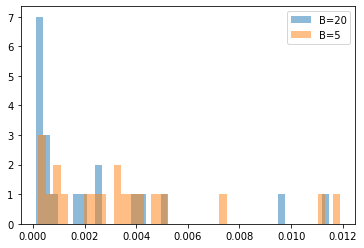

In [59]:
# One mystery will still remain though: why do we plateau to different values? Can we attribute those to 
# fluctuations in the total amount of noise or something else? I don't think the noise argument makes much 
# sense because we are using large N...

# As a quick first test, let's try doing a few d=2 runs and seeing how they do
C = 100000
n_train, n_valid, n_test = 3200, 1000, 1000
eps = 0.01 
r = 1
lr = 0.0001
reg = 0.001
n_epochs = 100
mse_small_b = []
mse_big_b = []
for d in [2]:
    for i in range(20):
        D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False)
        x_train = D1[0]
        y_train = D1[1]
        B=5
        w2, W1, mses = get_model(5, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, plot=False)
        mse_small_b.append(mses[-1])
        B=20
        w2, W1, mses = get_model(20, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, plot=False)
        mse_big_b.append(mses[-1])
plt.hist(mse_big_b, label="B=20", alpha=0.5, bins=40)
plt.hist(mse_small_b, label="B=5", alpha=0.5, bins=40)
plt.legend()
plt.show()
# Things are very clearly all plateauing to different values
# For each final outputted function, let's check--this seems ok? Let's look at the dist

In [60]:
C = 100000
n_train, n_valid, n_test = 320, 1000, 1000
eps = 0.01 
r = 1
B = 6
lr = 0.0001 * 5
reg = 0.001
n_epochs = 100
mses = []
for d in [2]:
    for i in range(500):
        D1, D2, x_valid, y_valid, x_test, y_test, W1_star, w2_star = get_data(r, d, C, n_train, n_valid, n_test, eps, test=False, no_noise=False)
        x_train = D1[0]
        y_train = D1[1]
        w2, W1, m = get_model(B, d, r, eps, lr, reg, n_epochs, x_train, y_train, x_valid, y_valid, n_train // 2, n_valid, D2, plot=False)
        mses.append(m[-1])

FHT MSE: 0.00010770354171761431  and NN MSE: 0.00010823066127086891
FHT MSE: 0.00075016899378114  and NN MSE: 0.0028863647324975715
FHT MSE: 0.014007270567039232  and NN MSE: 0.019652871218889742
FHT MSE: 0.007198311071490729  and NN MSE: 0.013606349257923771
FHT MSE: 0.0029575326885382526  and NN MSE: 0.008381093377237338
FHT MSE: 0.00046269216287107807  and NN MSE: 0.002093948480437679
FHT MSE: 0.018474267760238562  and NN MSE: 0.023055626615903834
FHT MSE: 0.0002200908719264047  and NN MSE: 0.0007149111572858231
FHT MSE: 0.01320287503287044  and NN MSE: 0.020125089731183075
FHT MSE: 0.007367085498819598  and NN MSE: 0.014459334170394992
FHT MSE: 0.0058424697665092  and NN MSE: 0.0112660175040148
FHT MSE: 0.0009743919664665264  and NN MSE: 0.0027216764521568555
FHT MSE: 0.007956688840055954  and NN MSE: 0.012306135991412571
FHT MSE: 0.009751967753595686  and NN MSE: 0.017085240806086737
FHT MSE: 0.0007214400061385372  and NN MSE: 0.0028971681368826037
FHT MSE: 0.0008552797999729884  

FHT MSE: 0.0019094082309348837  and NN MSE: 0.002929326256640854
FHT MSE: 0.0013149274525524328  and NN MSE: 0.0050034017766745825
FHT MSE: 0.000322021105805333  and NN MSE: 0.0006487872868977313
FHT MSE: 0.0005157436892483605  and NN MSE: 0.0019328728502763584
FHT MSE: 0.00033799401463926706  and NN MSE: 0.0007859722230675682
FHT MSE: 0.0015564558493052604  and NN MSE: 0.003242448318683447
FHT MSE: 0.0014324483077979226  and NN MSE: 0.0046308441939205075
FHT MSE: 0.0005651473547040663  and NN MSE: 0.002709684808864092
FHT MSE: 0.0022900077939424827  and NN MSE: 0.005960022824735975
FHT MSE: 0.00790441056232578  and NN MSE: 0.01241131151528375
FHT MSE: 0.0001537120604936852  and NN MSE: 0.0002763580324784853
FHT MSE: 0.0005157399740437202  and NN MSE: 0.0012744235786863957
FHT MSE: 0.0007787469572767254  and NN MSE: 0.0026627036419028913
FHT MSE: 0.009972047103259654  and NN MSE: 0.014288985487276534
FHT MSE: 0.0038912589982176547  and NN MSE: 0.006368768793082935
FHT MSE: 0.0001173150

FHT MSE: 0.002071715476690241  and NN MSE: 0.005066677221791119
FHT MSE: 0.00022241837739386155  and NN MSE: 0.00025068722691472776
FHT MSE: 0.0013403123046634598  and NN MSE: 0.0032933372855476835
FHT MSE: 0.0003865009202766129  and NN MSE: 0.0011203156995188718
FHT MSE: 0.003517415826985897  and NN MSE: 0.0054745697635965535
FHT MSE: 0.0005034489890261592  and NN MSE: 0.0010679153070950924
FHT MSE: 0.02534506791326988  and NN MSE: 0.033813423853262366
FHT MSE: 0.0029885364814371275  and NN MSE: 0.00838096666861236
FHT MSE: 0.009332690580454113  and NN MSE: 0.013967331816287544
FHT MSE: 0.0005086344954537802  and NN MSE: 0.0011139977485221642
FHT MSE: 0.0009660274453577962  and NN MSE: 0.003532051217396263
FHT MSE: 0.0033546584599157036  and NN MSE: 0.005532091002056026
FHT MSE: 0.001690119515519931  and NN MSE: 0.0040169445056859295
FHT MSE: 0.005996029747575085  and NN MSE: 0.008985517497526217
FHT MSE: 0.00022927832344921335  and NN MSE: 0.00029890514600392534
FHT MSE: 0.0120146655

FHT MSE: 0.0012497207707688135  and NN MSE: 0.001840312992912763
FHT MSE: 0.00014464291352777968  and NN MSE: 0.00036952059355883557
FHT MSE: 0.0002832895915008502  and NN MSE: 0.0006488380154842453
FHT MSE: 0.00011026272032149112  and NN MSE: 0.005388987343681752
FHT MSE: 0.010782004344064278  and NN MSE: 0.013139796242700338
FHT MSE: 0.007719350368848871  and NN MSE: 0.014531706601884154
FHT MSE: 0.0011088189326293049  and NN MSE: 0.0021489111567958245
FHT MSE: 0.0001217355179196186  and NN MSE: 0.00013633879521386135
FHT MSE: 0.0002604445567175244  and NN MSE: 0.00047060103184503986
FHT MSE: 0.014609411884955056  and NN MSE: 0.024388216928253423
FHT MSE: 0.0008529126068318293  and NN MSE: 0.0025696804071650317
FHT MSE: 0.00019627404914705602  and NN MSE: 0.0006941264360158157
FHT MSE: 0.013811273441050959  and NN MSE: 0.019398412989393578
FHT MSE: 0.01077382795018987  and NN MSE: 0.01435428558514759
FHT MSE: 0.001820052418354801  and NN MSE: 0.006691941791323865
FHT MSE: 0.000119940

0.0032247013055387895


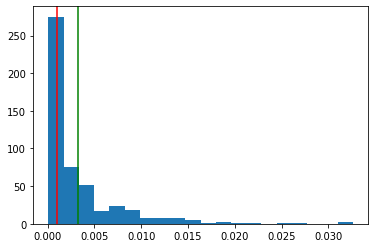

In [61]:
plt.hist(mses, bins=20)
plt.axvline(x=0.001, color='r')
plt.axvline(x=np.mean(mses), color='g')
print(np.mean(mses))
plt.show()

In [ ]:
# So the above is not totally unreasonable...
# What happens to the distributions as we vary B and epsilon? In general, I would expect
# that if we increase B we get better results and it MUST get worse as we increase eps...


# Finish this later!!